### Immunological Illusion Training Model

#### Environment setup

In [ ]:
K_PATIENT = 5

## Parametri da provare
## K_PATIENT in [3, 5, 7, 10, 15, 20]

## feature_cols = ["MHCI", "MHCII", "Coactivation_molecules", "Effector_cells", "T_cell_traffic", "NK_cells", "T_cells", "B_cells",
##                "M1_signatures", "Th1_signature", "Antitumor_cytokines", "Checkpoint_inhibition", "Treg", "T_reg_traffic", "MDSC",
##                "MDSC_traffic", "Macrophages", "Macrophage_DC_traffic", "Th2_signature"] (queste le features significative), puoi provare solo con queste o con tutte (se vuoi provare con tutte, modifica il codice riga 9 sezione Model)

## hidden è il numero di neuroni negli strati intermedi della rete, prova questo range: [32, 64, 128, 256]
## num_layers è il numero di layers della rete, prova questo range: [2, 3, 4]
## dropout: frazione di neuroni che vengono annullati durante il training, per evitare l'overfitting, prova questo range: [0.1, 0.2, 0.25, 0.3]
## EPOCHS = 300, numero di epoche per cui la rete è addestrata, arriva massimo a 1000
## numero di epoche che la rete può sopportare (senza migliorare la previsione), prima di fermarsi, ti evita l'overfitting (early stopping), prova: dipende da EPOCHS
## più epochs è grande, più patience è grande, più epochs è piccolo, più patience è piccolo. esempio: epochs = 1000, patience = 80, epochs = 300, patience = 40, ecc.
## nel codice trovi k e metric: servono a costruire i grafi. prova k nel range: 2,3,4,5,6,7,8,9,10 e metric prova euclidean, cosine (meglio cosine).

In [ ]:
## Install dependencies
!pip install -q torch_geometric

## Mount Drive
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

## Paths
data_path  = "/content/drive/MyDrive/Immunological_Illusion/Data/"
code_path  = "/content/drive/MyDrive/Immunological_Illusion/Code/"
model_path = "/content/drive/MyDrive/Immunological_Illusion/Model/"

## Core scientific stack
import os
import glob
import time
import random
from collections import Counter
import numpy as np
import pandas as pd
import torch

## Deep learning (PyTorch)
import torch.nn as nn
import torch.nn.functional as F

## Graph deep learning (PyG)
from torch_geometric.nn import SAGEConv
import networkx as nx
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
plt.style.use("ggplot")
sns.set_context("talk")

## ML & preprocessing
from sklearn.model_selection import (
train_test_split,
    StratifiedKFold,
    GridSearchCV,
    ParameterGrid,
    cross_val_score,
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

## Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    confusion_matrix,
    classification_report,
    make_scorer,
)

## Statistics & utilities
import scipy.stats as stats
from tqdm import tqdm
import os, zipfile
import shutil
from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.4 MB/s eta 0:00:00
Mounted at /content/drive


#### Load Data

In [ ]:
## Load TRACERx
df = pd.read_csv(
    os.path.join(data_path, "df_immuno.txt"),
    sep = "\t")

## Keep region id from index
df = df.reset_index(names = "Region")

## Rename once
df = df.rename(columns = {"Class": "Class_Region"})

## Encode Class_Region
region_map = {
    1: "Hom - IE",
    0: "Hom - D",
    2: "Het - D"
}
df["Class_Region"] = (
    df["Class_Region"]
      .map(region_map)
      .fillna("Het - IE")
)

# Create Class_Patient
df["Class_Patient"] = df["Class_Region"].replace({
    "Hom - IE": "Hom - IE",
    "Hom - D":  "Hom - D",
    "Het - IE": "Het",
    "Het - D":  "Het",
})

## Create Patient_Id
df["Patient_Id"] = df["Region"].str.split("_", n=1).str[0]

## Sanity check
print(df.shape)
df.head()

(746, 33)


Region      MHCI     MHCII  Coactivation_molecules  \
0  CRUK0001_SU_T1-R1  0.952014  0.866253                0.552840   
1  CRUK0001_SU_T1-R3  0.576800  0.676147               -0.081676   
2  CRUK0003_SU_T1-R1 -0.106396  0.795923               -0.256202   
3  CRUK0003_SU_T1-R2 -0.878542  0.795287               -0.225489   
4  CRUK0003_SU_T1-R3  0.227839  0.859221                0.467034   

   Effector_cells  T_cell_traffic  NK_cells   T_cells   B_cells  \
0        0.844820        0.812133  0.234646  1.586741  2.110434   
1        0.121912        0.440200  0.245301  0.395349  0.211595   
2       -0.504893        0.041004 -0.761232  0.478818 -0.283649   
3       -0.962678       -0.789986 -1.265400  0.021864 -1.190620   
4       -0.562009        0.370099 -0.798579  0.113538  0.042142   

   M1_signatures  ...       CAF    Matrix  Matrix_remodeling  Angiogenesis  \
0       0.145437  ...  0.257950  0.046725          -1.073292     -0.848095   
1      -0.177743  ...  1.281431  1.296976           0.344860      1.524617   
2      -1.654506  ... -0.083440 -0.426445          -0.664807     -0.573735   
3      -1.883906  ... -0.555140  0.046518          -0.729836     -1.003708   
4      -0.658745  ...  1.202534  1.242899           0.865450      1.261993   

   Endothelium  Proliferation_rate  EMT_signature  Class_Region  \
0     0.559639           -0.521372      -0.554121      Het - IE   
1     2.129626           -0.770155       0.816213       Het - D   
2     0.003760           -1.868350      -1.185590      Het - IE   
3    -0.344724           -1.983459      -1.290959       Het - D   
4     1.380700           -1.681031       0.432321       Het - D   

   Class_Patient  Patient_Id  
0            Het    CRUK0001  
1            Het    CRUK0001  
2            Het    CRUK0003  
3            Het    CRUK0003  
4            Het    CRUK0003  

[5 rows x 33 columns]

#### EDA

In [ ]:
## Palette
class_palette = {
    "Hom - IE": "#8c1d04",   ## dark red
    "Het - IE": "#e07b39",   ## orange
    "Het - D":  "#a8916f",   ## brownish
    "Hom - D":  "#6f8f82",   ## greenish
}

## Plot
def plot_signatures_facet(df, cols, group_col, order, n_cols = 3, chunk_size = 9,
                          show_points = True, height = 4.2, aspect = 1.3,
                          palette = class_palette):
    base = df[[group_col] + cols].copy()
    long = base.melt(
        id_vars = group_col,
        var_name = "Signature",
        value_name = "Score"
    )
    long[group_col] = pd.Categorical(
        long[group_col],
        categories = order,
        ordered = True
    )

    for start in range(0, len(cols), chunk_size):
        sub_sigs = cols[start:start + chunk_size]
        sub = long[long["Signature"].isin(sub_sigs)]

        g = sns.catplot(
            data = sub,
            x = group_col,
            y = "Score",
            col = "Signature",
            col_wrap = n_cols,
            order = order,
            kind = "boxen",
            palette = palette,
            sharey = False,
            height = height,
            aspect = aspect,
            legend = False
        )

        if show_points:
            for ax in g.axes.flatten():
                sig = ax.get_title().split(" = ")[-1]
                sns.stripplot(
                    data = sub[sub["Signature"] == sig],
                    x = group_col,
                    y = "Score",
                    order = order,
                    hue = group_col,
                    palette = palette,
                    dodge = False,
                    alpha = 0.45,
                    size = 3.2,
                    jitter = 0.25,
                    ax = ax,
                    legend = False
                )

        ## Remove per-plot labels
        for ax in g.axes.flatten():
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.tick_params(axis = "x", labelrotation = 30)

        ## Global title
        g.fig.suptitle(
            f"{group_col} — signatures {start+1}–{min(start+chunk_size, len(cols))}",
            fontsize = 18,
            y = 1.05
        )

        ## One global legend (color-only)
        handles = [
            Patch(facecolor = palette[c], edgecolor = "black", label = c)
            for c in order if c in palette
        ]
        g.fig.legend(
            handles = handles,
            title = group_col,
            loc = "upper right",
            bbox_to_anchor = (0.98, 0.92),
            frameon = True
        )

        plt.tight_layout()
        plt.show()

/tmp/ipython-input-2877149939.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


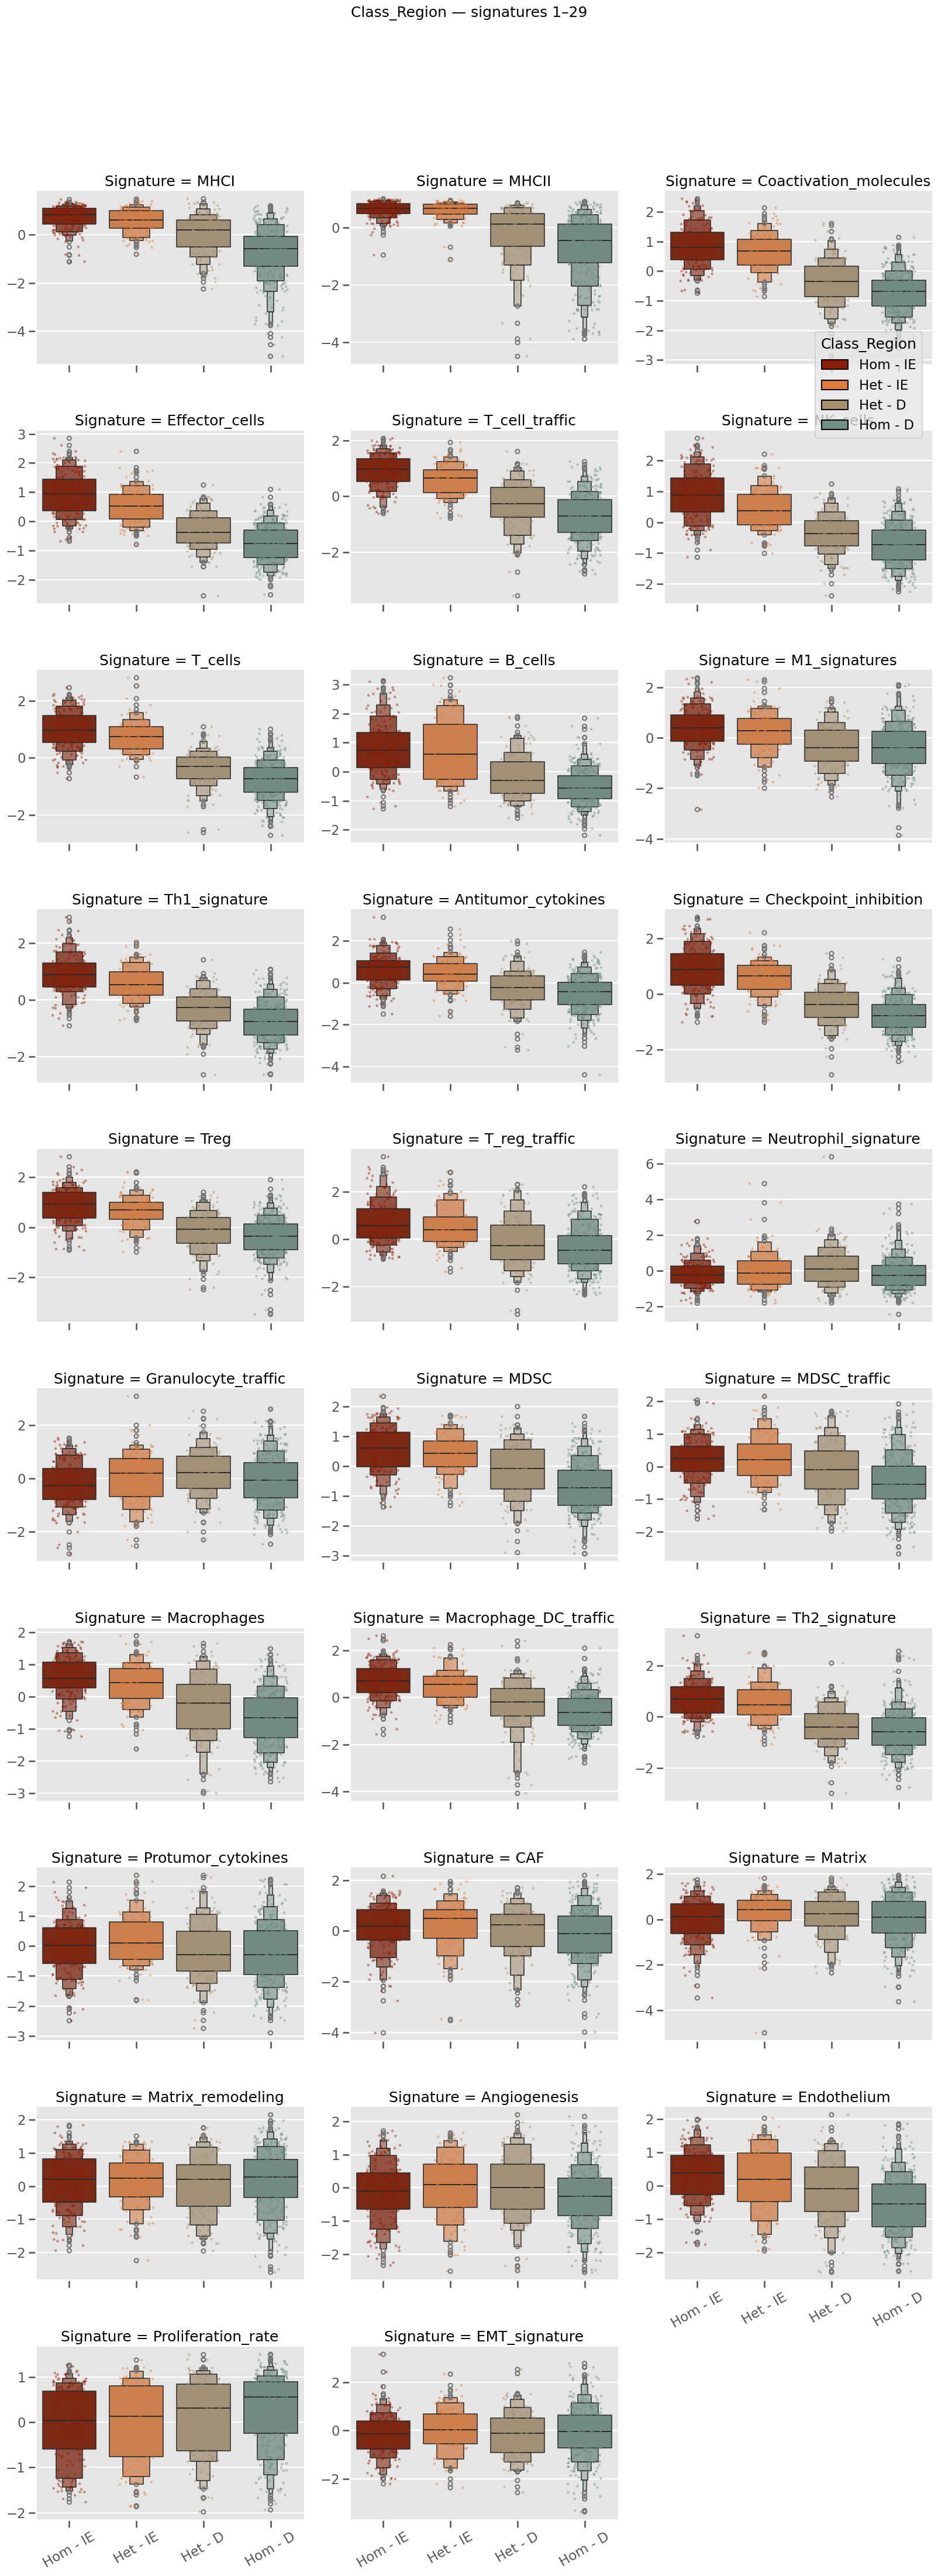

In [ ]:
## Region
order_region = ["Hom - IE", "Het - IE", "Het - D", "Hom - D"]
plot_cols = df.columns.tolist()[1:30]

plot_signatures_facet(
    df = df,
    cols = plot_cols,
    group_col = "Class_Region",
    order = order_region,
    n_cols = 3,
    chunk_size = 29,
    show_points = True,
    height = 4.2,
    aspect = 1.3,
    palette = class_palette)

/tmp/ipython-input-2877149939.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


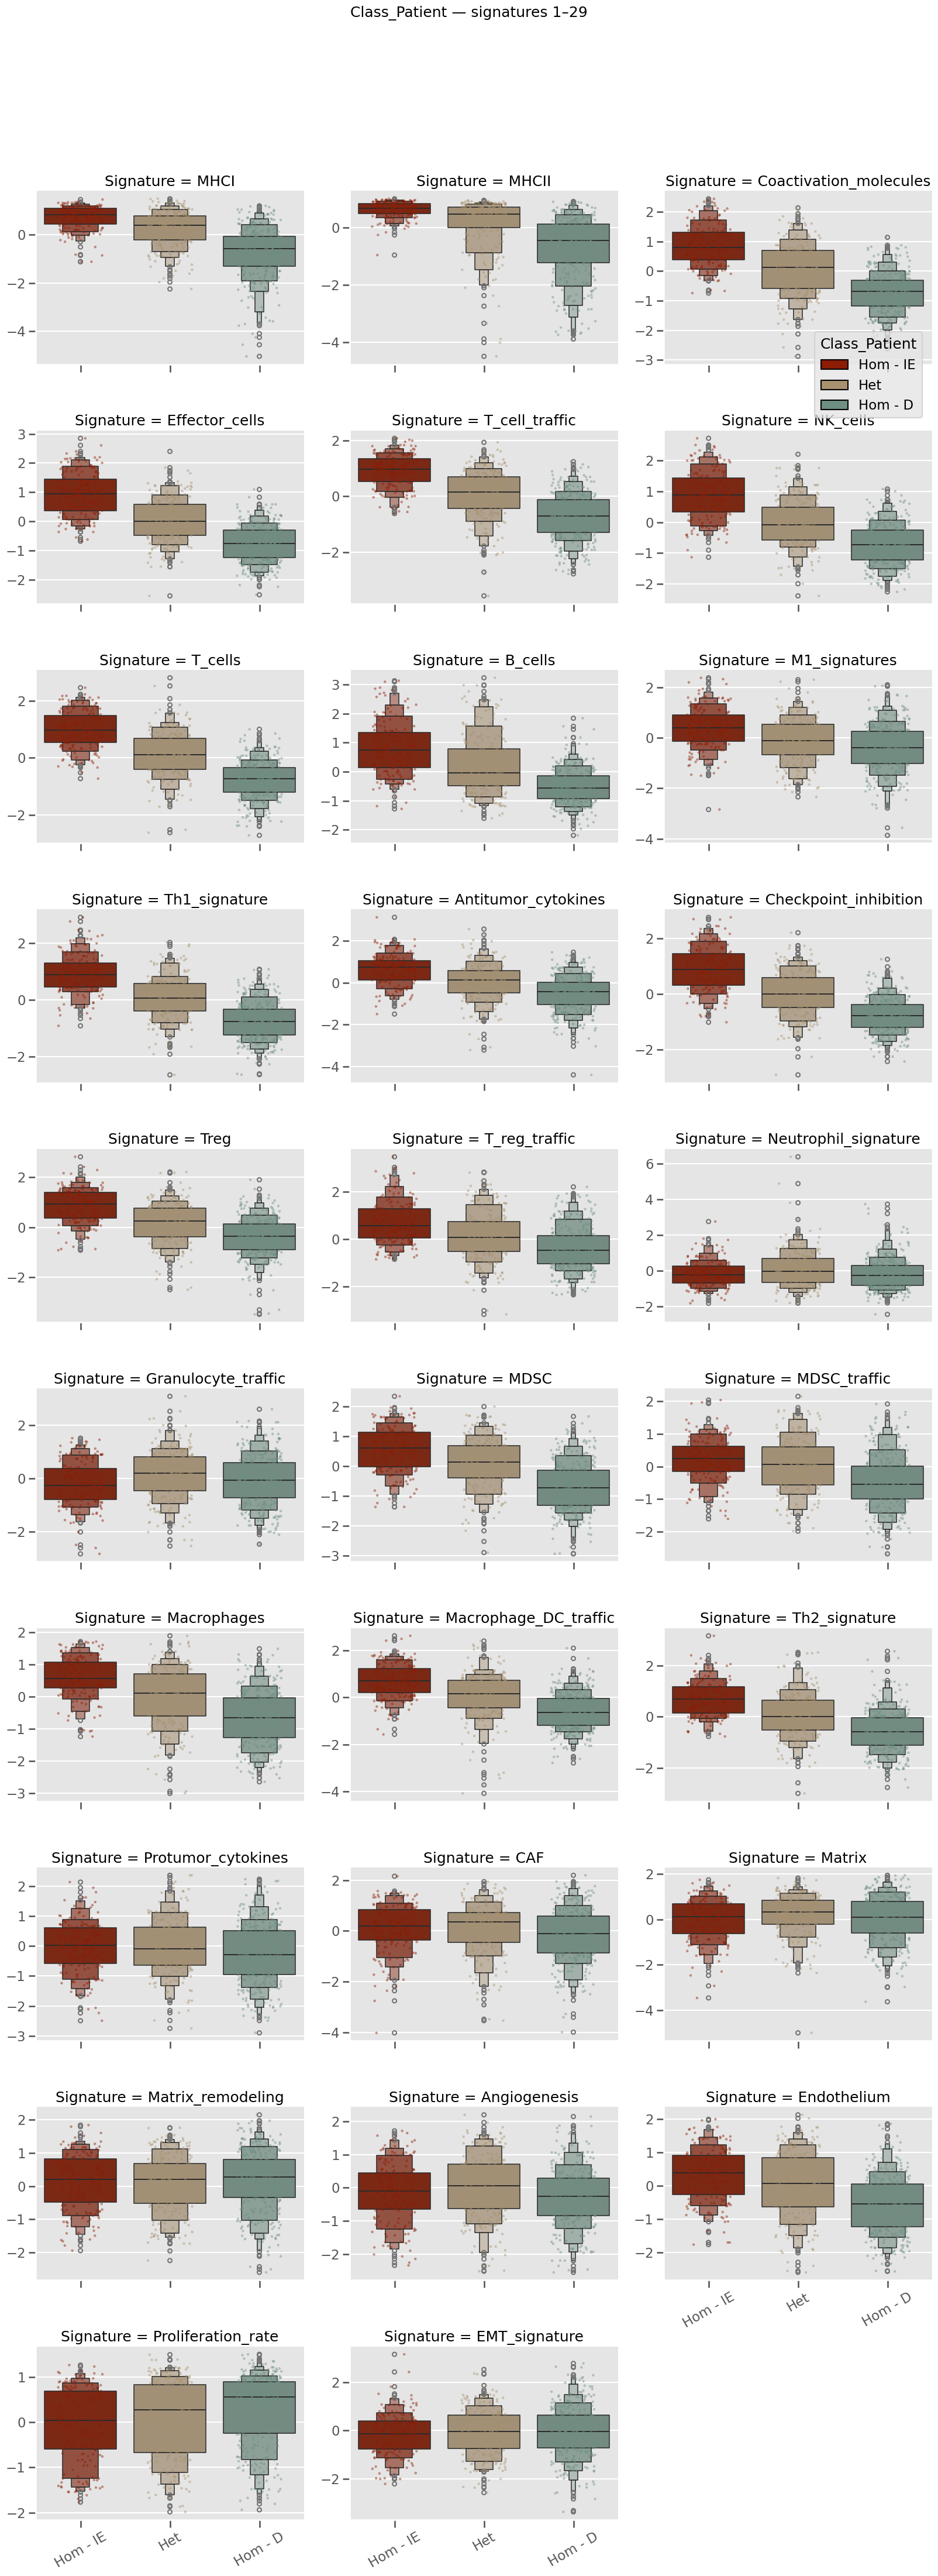

In [ ]:
## Patient

## Palette
class_palette = {
    "Hom - IE": "#8c1d04", ## dark red
    "Het":  "#a8916f",     ## brownish
    "Hom - D":  "#6f8f82", ## greenish
}
order_patient = ["Hom - IE", "Het", "Hom - D"]
plot_cols = df.columns.tolist()[1:30]

plot_signatures_facet(
    df = df,
    cols = plot_cols,
    group_col = "Class_Patient",
    order = order_patient,
    n_cols = 3,
    chunk_size = 29,
    show_points = True,
    height = 4.2,
    aspect = 1.3,
    palette = class_palette)

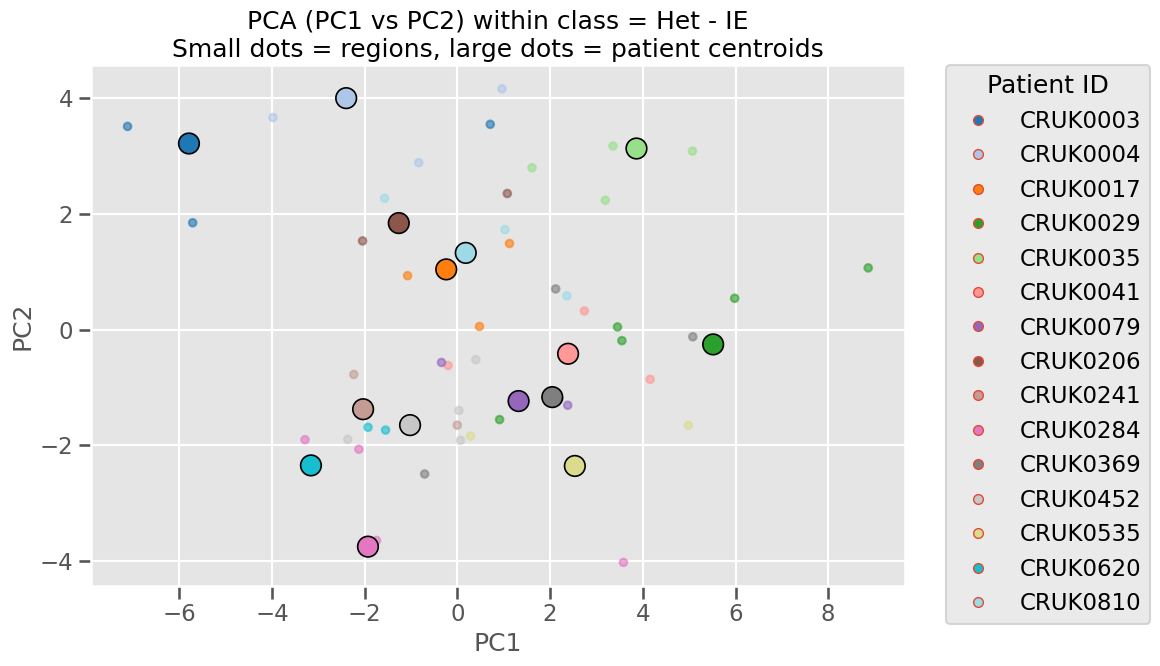

In [ ]:
## PCA centroid
def pca_scatter_one_class_with_centroids(df, class_name = "Hom - IE", scale = True, max_patients = 20, seed = 42):
    sub = df[df["Class_Region"] == class_name].copy()

    ## Feature columns
    meta_cols = {"Class_Region", "Region", "Patient_Id", "Class_Patient"}
    feat_cols = [c for c in sub.columns
                 if c not in meta_cols and pd.api.types.is_numeric_dtype(sub[c])]
    X = sub[feat_cols].to_numpy()

    if scale:
        X = StandardScaler().fit_transform(X)

    ## PCA fit on region-level data
    pca = PCA(n_components = 2, random_state = seed)
    Z = pca.fit_transform(X)
    sub["PC1"] = Z[:, 0]
    sub["PC2"] = Z[:, 1]

    ## keep top-N patients
    if max_patients is not None:
        top_patients = sub["Patient_Id"].value_counts().head(max_patients).index
        sub = sub[sub["Patient_Id"].isin(top_patients)]

    ## Categorical patient codes
    patients = sub["Patient_Id"].astype("category")
    sub["pid_code"] = patients.cat.codes
    pid_labels = patients.cat.categories
    cmap = plt.get_cmap("tab10" if len(pid_labels) <= 10 else "tab20")
    plt.figure(figsize = (12, 7))

    ## Region-level points
    plt.scatter(
        sub["PC1"],
        sub["PC2"],
        c = sub["pid_code"],
        cmap = cmap,
        s = 30,
        alpha = 0.6,
        label = "Regions")

    ## Patient centroids
    centroids = (
        sub.groupby("Patient_Id")[feat_cols]
        .mean()
        .loc[pid_labels])
    Xc = centroids.to_numpy()
    if scale:
        Xc = StandardScaler().fit_transform(Xc)
    Zc = pca.transform(Xc)

    plt.scatter(
        Zc[:, 0],
        Zc[:, 1],
        c=range(len(pid_labels)),
        cmap = cmap,
        s = 220,
        edgecolor = "black",
        linewidth = 1.2,
        marker = "o",
        alpha = 1.0,
        label = "Patient centroid")

    ## Legend (patients)
    handles = [
        plt.Line2D(
            [0], [0],
            marker = "o",
            linestyle = "",
            markersize = 7,
            markerfacecolor = cmap(i / max(1, len(pid_labels) - 1)),
            label = pid)
        for i, pid in enumerate(pid_labels)]

    plt.legend(
        handles = handles,
        title = "Patient ID",
        bbox_to_anchor = (1.05, 1),
        loc = "upper left",
        borderaxespad = 0.
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(
        f"PCA (PC1 vs PC2) within class = {class_name}\n"
        "Small dots = regions, large dots = patient centroids"
    )
    plt.tight_layout()
    plt.show()


## Run
pca_scatter_one_class_with_centroids(
    df,
    class_name = "Het - IE",
    scale = True,
    max_patients = 15)

/tmp/ipython-input-567084806.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels = patients, showfliers = False)


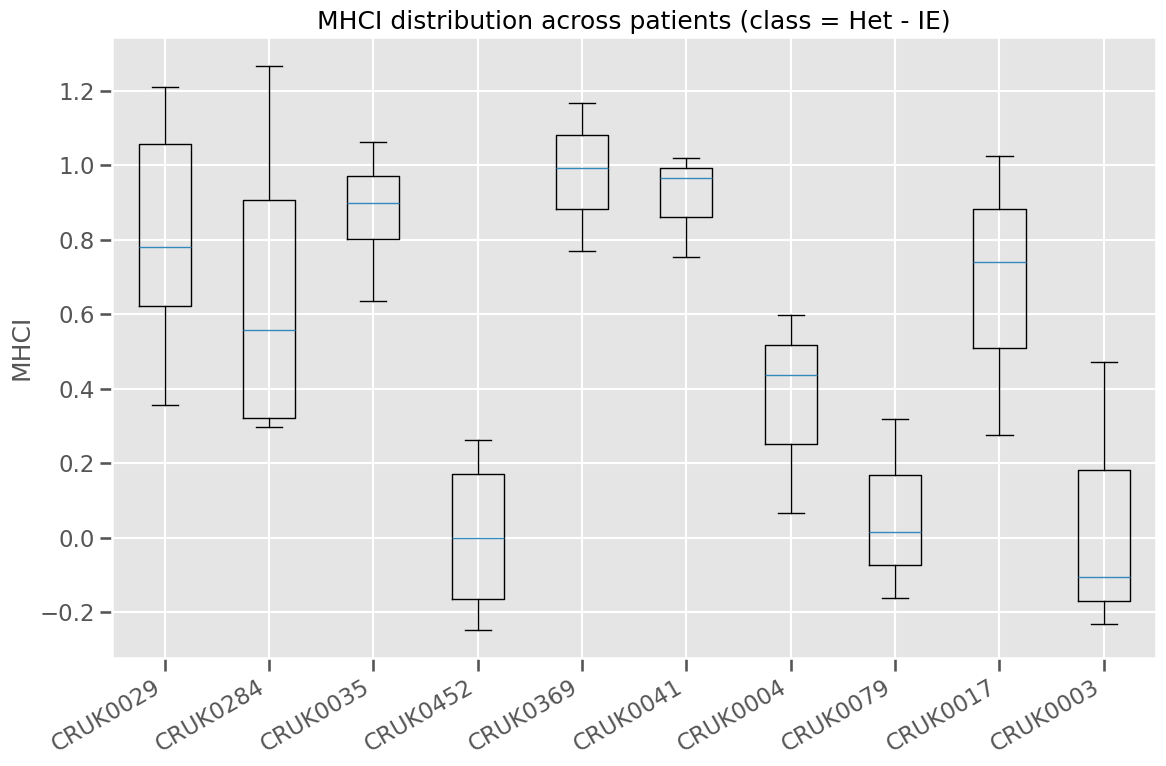

/tmp/ipython-input-567084806.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels = patients, showfliers = False)


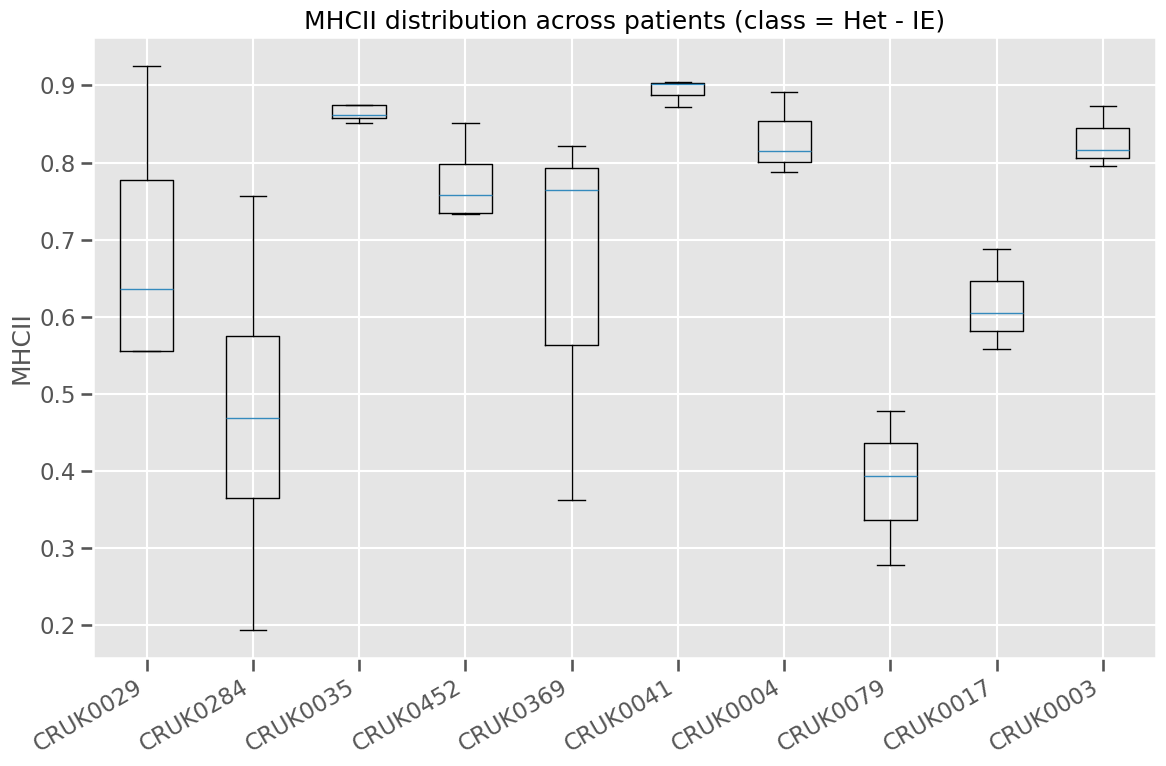

/tmp/ipython-input-567084806.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels = patients, showfliers = False)


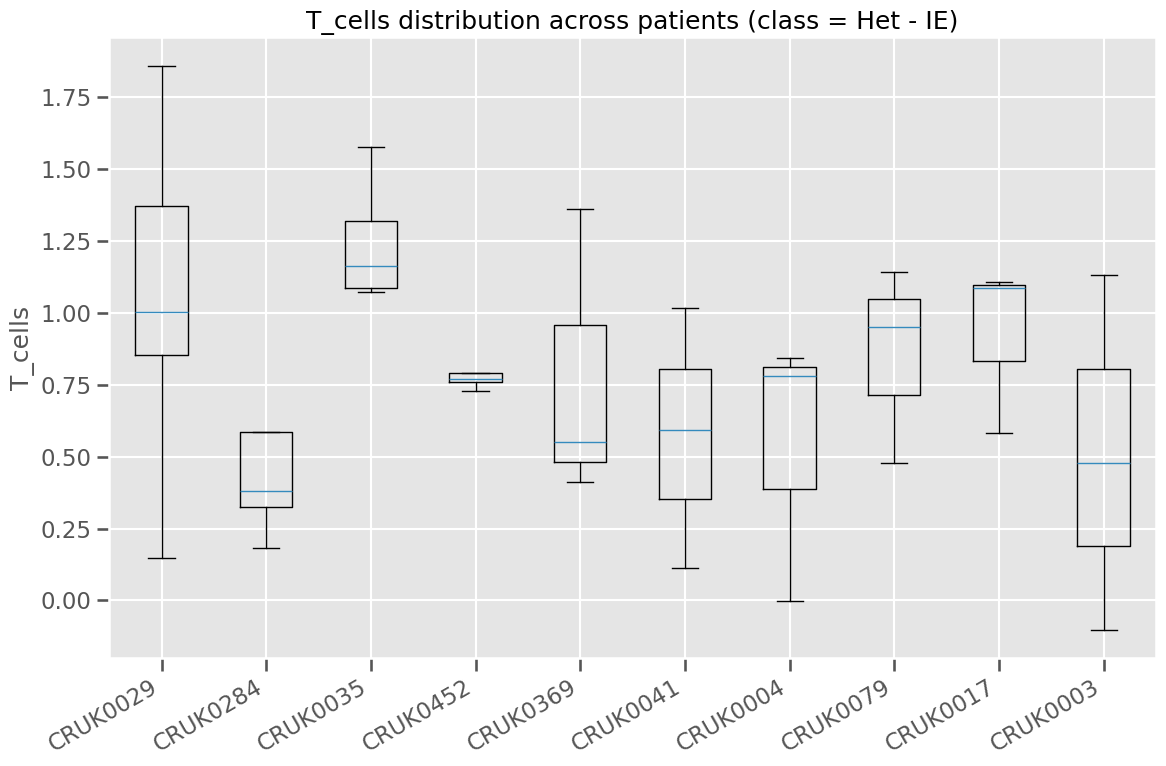

/tmp/ipython-input-567084806.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels = patients, showfliers = False)


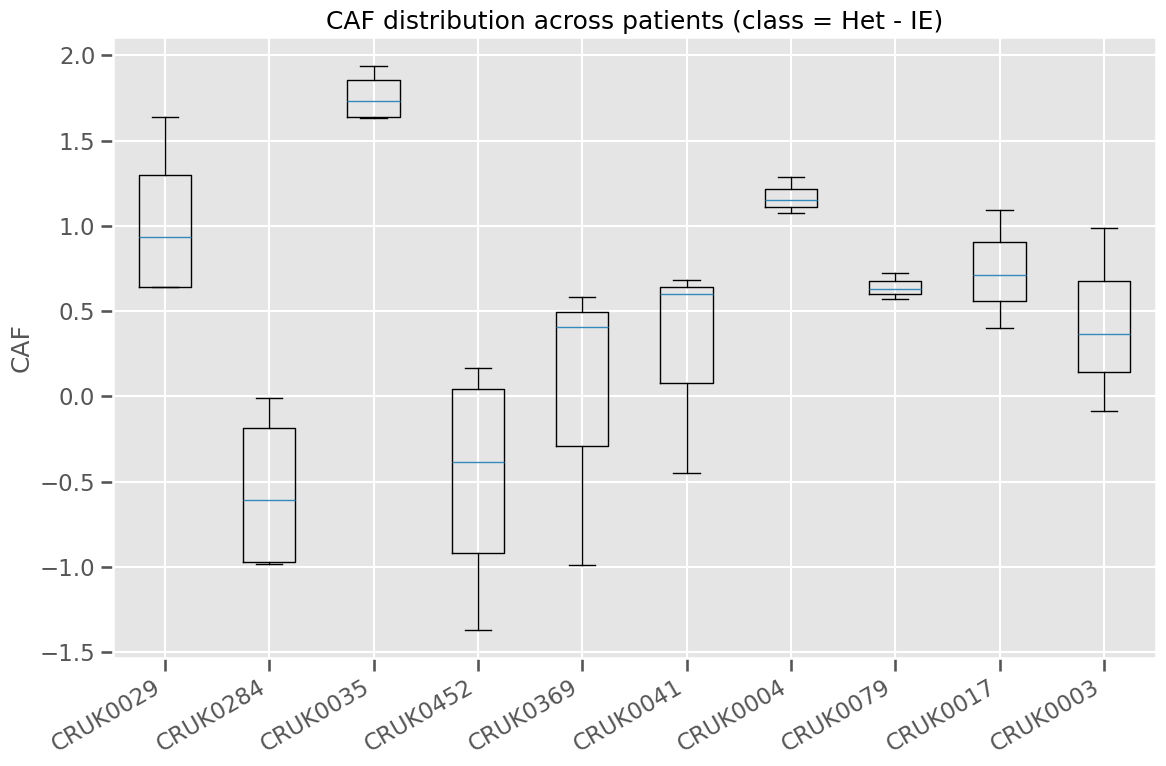

/tmp/ipython-input-567084806.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels = patients, showfliers = False)


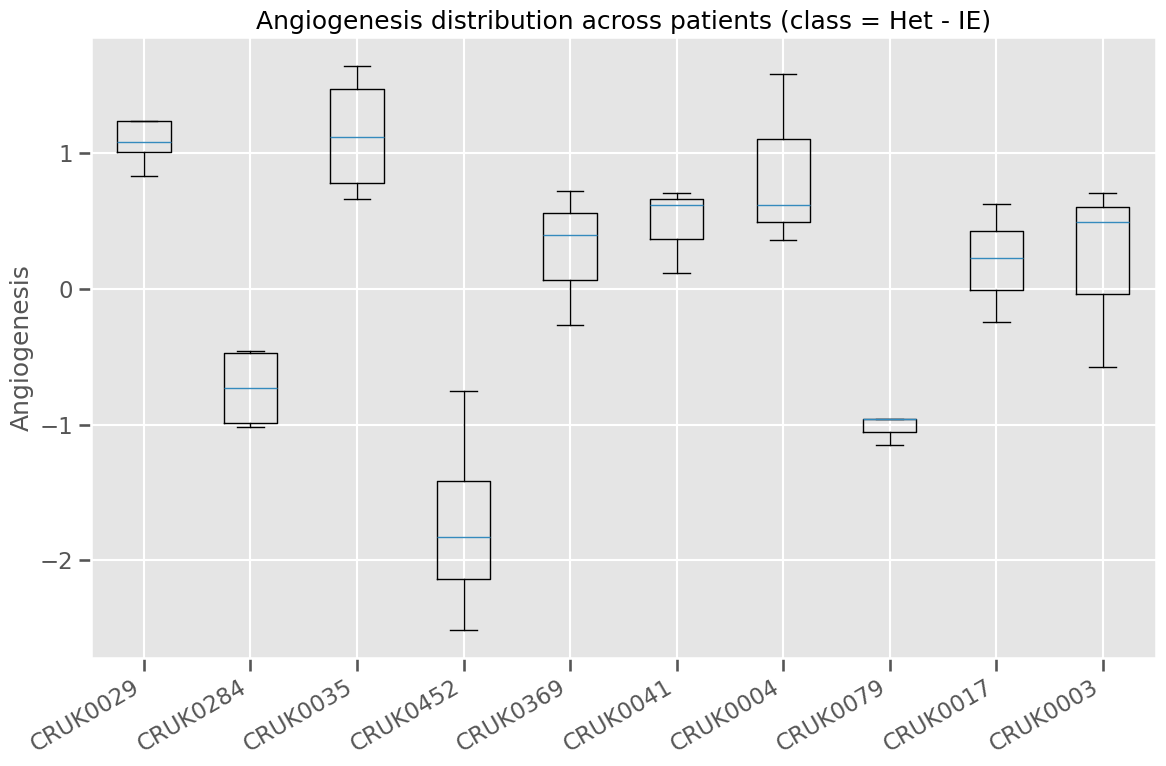

In [ ]:
## Boxplot
def boxplots_signatures_by_patient(df, class_name = "Hom - IE", signatures = None, max_patients = 12):
    sub = df[df["Class_Region"] == class_name].copy()

    if signatures is None:
        ## Pick a few common ones as default; replace with your favorites
        candidates = ["MHCI", "MHCII", "T_cells", "NK_cells", "CAF"]
        signatures = [s for s in candidates if s in sub.columns]

    ## Keep top patients for readability
    top_patients = sub["Patient_Id"].value_counts().head(max_patients).index
    sub = sub[sub["Patient_Id"].isin(top_patients)]

    patients = list(top_patients)

    for sig in signatures:
        data = [sub.loc[sub["Patient_Id"] == p, sig].dropna().values for p in patients]

        plt.figure(figsize = (12, 8))
        plt.boxplot(data, labels = patients, showfliers = False)
        plt.title(f"{sig} distribution across patients (class = {class_name})")
        plt.ylabel(sig)
        plt.xticks(rotation = 30, ha = "right")
        plt.tight_layout()
        plt.show()

## Run
boxplots_signatures_by_patient(df, class_name = "Het - IE", signatures = ["MHCI", "MHCII", "T_cells",
                                                                          "CAF", "Angiogenesis"], max_patients = 10)

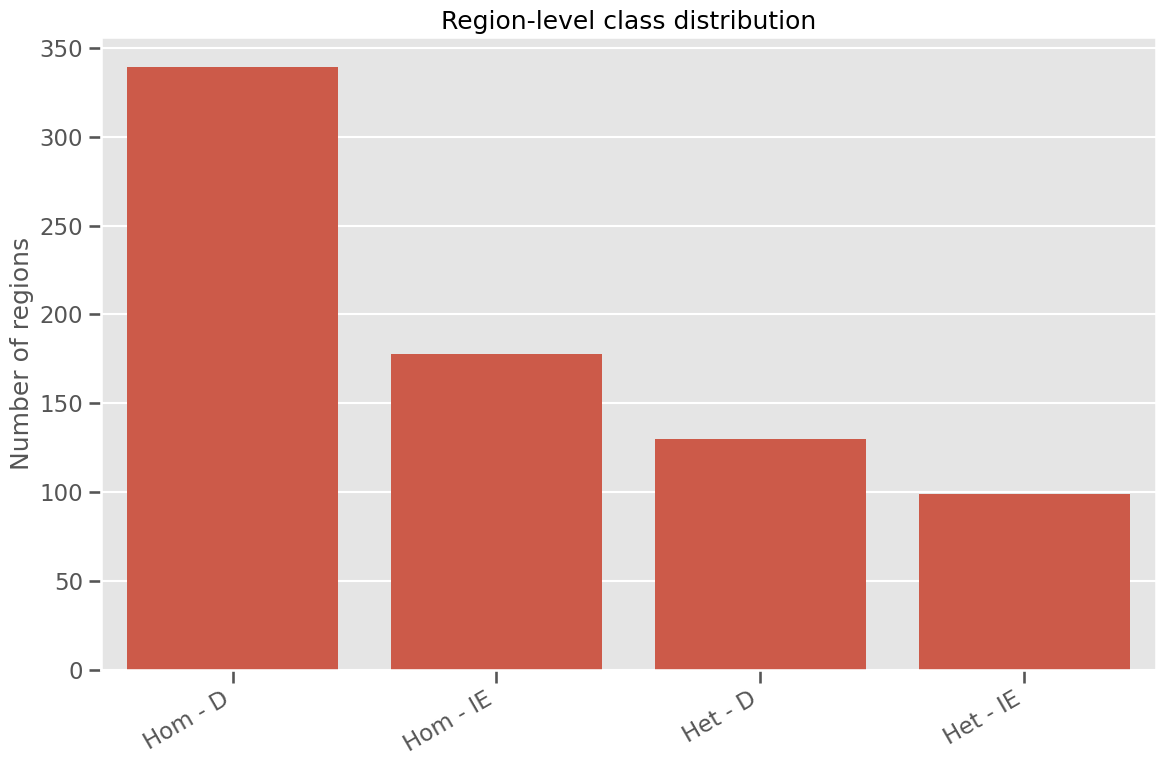

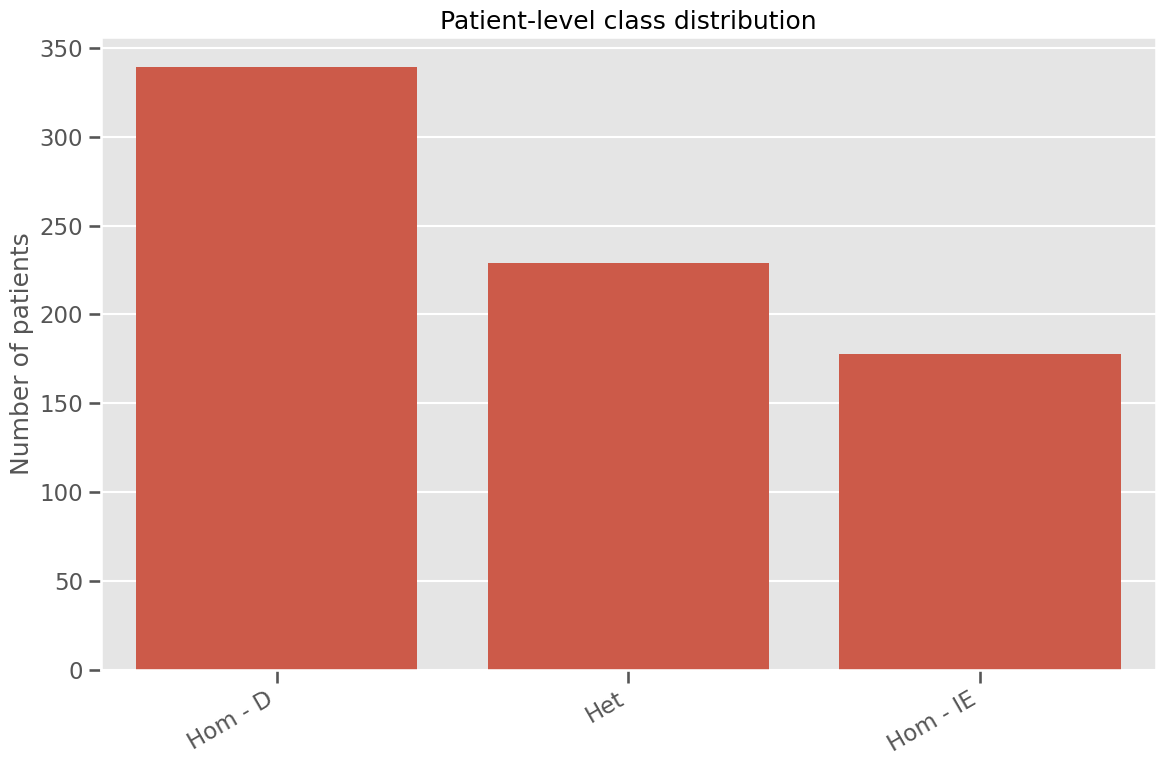

In [ ]:
## Check
plt.figure(figsize = (12, 8))
sns.countplot(
    data = df,
    x = "Class_Region",
    order = df["Class_Region"].value_counts().index
)

plt.xlabel("")
plt.ylabel("Number of regions")
plt.title("Region-level class distribution")
plt.xticks(rotation = 30, ha = "right")
plt.tight_layout()
plt.show()

plt.figure(figsize = (12, 8))
sns.countplot(
    data = df,
    x = "Class_Patient",
    order = df["Class_Patient"].value_counts().index
)

plt.xlabel("")
plt.ylabel("Number of patients")
plt.title("Patient-level class distribution")
plt.xticks(rotation = 30, ha = "right")
plt.tight_layout()
plt.show()

In [ ]:
## Number of regions for patients
regions_per_patient = df.groupby("Patient_Id").size()
min(regions_per_patient), max(regions_per_patient)

(2, 11)

In [ ]:
## Extract features
feature_cols = df.columns.tolist()[1:30]

#### Scenario 4

##### Model

In [ ]:
## Colonne base
patient_col = "Patient_Id"
region_id_col = "Region"
region_label_col = "Class_Region"

## Feature = tutte le colonne numeriche/continue eccetto label/id
exclude = {patient_col, region_id_col, region_label_col, "Class_Patient"}
feature_cols = [c for c in df.columns if c not in exclude]
feature_cols = ["MHCI", "MHCII", "Coactivation_molecules", "Effector_cells", "T_cell_traffic", "NK_cells", "T_cells", "B_cells",
                "M1_signatures", "Th1_signature", "Antitumor_cytokines", "Checkpoint_inhibition", "Treg", "T_reg_traffic", "MDSC",
                "MDSC_traffic", "Macrophages", "Macrophage_DC_traffic", "Th2_signature"]

## Sanity
print("N features:", len(feature_cols))
print("Feature cols:", feature_cols[:8], "...")

## Encode Class_Region -> int [0..C-1]
region_class_names, y_region = np.unique(df[region_label_col].astype(str).values, return_inverse = True)
y_region = torch.tensor(y_region, dtype = torch.long)

print("Region classes:", list(region_class_names))
num_classes = len(region_class_names)

## Patient ids universe (string)
patient_ids = df[patient_col].astype(str).unique()
patient_id_to_idx = {pid: i for i, pid in enumerate(patient_ids)}

## Per ogni regione, indice del patient node
region_patient_idx = torch.tensor(df[patient_col].astype(str).map(patient_id_to_idx).values, dtype = torch.long)

N features: 19
Feature cols: ['MHCI', 'MHCII', 'Coactivation_molecules', 'Effector_cells', 'T_cell_traffic', 'NK_cells', 'T_cells', 'B_cells'] ...
Region classes: ['Het - D', 'Het - IE', 'Hom - D', 'Hom - IE']


In [ ]:
x_region = torch.tensor(df[feature_cols].values, dtype = torch.float)

## Patient features = mean delle region features per paziente
patient_feat_df = (df.assign(_pid=df[patient_col].astype(str))
                     .groupby("_pid")[feature_cols].mean()
                     .reindex(patient_ids))

x_patient = torch.tensor(patient_feat_df.values, dtype = torch.float)

print("x_region:", x_region.shape, "| x_patient:", x_patient.shape)

x_region: torch.Size([746, 19]) | x_patient: torch.Size([244, 19])


In [ ]:
## Region region graph
def build_region_region_intra_knn(df, feature_cols, patient_col = "Patient_Id", k = 3, metric = "euclidean"):
    rows = []
    for pid, sub in df.groupby(patient_col):
        idx = sub.index.values
        X = sub[feature_cols].values
        n = len(idx)
        if n <= 1:
            continue
        kk = min(k, n-1)
        nnbr = NearestNeighbors(n_neighbors = kk+1, metric = metric).fit(X)
        neigh = nnbr.kneighbors(X, return_distance = False)  ## include self in first col
        for i_local, nbrs in enumerate(neigh):
            src = idx[i_local]
            for j_local in nbrs[1:]:  ## skip self
                dst = idx[j_local]
                rows.append((src, dst))
                rows.append((dst, src))  ## undirected (as directed both ways)
    if len(rows) == 0:
        return torch.empty((2,0), dtype = torch.long)
    edge_index = torch.tensor(rows, dtype = torch.long).t().contiguous()
    return edge_index

edge_rr = build_region_region_intra_knn(df, feature_cols, patient_col = patient_col, k = K_PATIENT, metric = "cosine")
print("edge_rr:", edge_rr.shape)

edge_rr: torch.Size([2, 3746])


In [ ]:
## Region patient
num_regions = len(df)
src_region = torch.arange(num_regions, dtype = torch.long)
dst_patient = region_patient_idx

edge_rp = torch.stack([src_region, dst_patient], dim = 0)  ## region -> patient
edge_pr = torch.stack([dst_patient, src_region], dim = 0)  ## patient -> region

print("edge_rp:", edge_rp.shape, "| edge_pr:", edge_pr.shape)

edge_rp: torch.Size([2, 746]) | edge_pr: torch.Size([2, 746])


In [ ]:
## Patient patient graph
def build_patient_patient_knn(x_patient, k = 10, metric = "euclidean"):
    X = x_patient.numpy()
    n = X.shape[0]
    if n <= 1:
        return torch.empty((2,0), dtype = torch.long)
    kk = min(k, n-1)
    nnbr = NearestNeighbors(n_neighbors = kk+1, metric = metric).fit(X)
    neigh = nnbr.kneighbors(X, return_distance = False)
    rows = []
    for i in range(n):
        for j in neigh[i, 1:]:  ## skip self
            rows.append((i, j))
            rows.append((j, i))
    return torch.tensor(rows, dtype = torch.long).t().contiguous()

edge_pp = build_patient_patient_knn(x_patient, k = K_PATIENT, metric = "cosine")
print("edge_pp:", edge_pp.shape)

edge_pp: torch.Size([2, 2440])


In [ ]:
## Hetero graph
data = HeteroData()

data["region"].x = x_region
data["region"].y = y_region

data["patient"].x = x_patient

## Edges
data["region", "intra", "region"].edge_index = edge_rr
data["region", "belongs_to", "patient"].edge_index = edge_rp
data["patient", "has_region", "region"].edge_index = edge_pr
data["patient", "knn", "patient"].edge_index = edge_pp

print(data)

HeteroData(
  region={
    x=[746, 19],
    y=[746],
  },
  patient={ x=[244, 19] },
  (region, intra, region)={ edge_index=[2, 3746] },
  (region, belongs_to, patient)={ edge_index=[2, 746] },
  (patient, has_region, region)={ edge_index=[2, 746] },
  (patient, knn, patient)={ edge_index=[2, 2440] }
)


In [ ]:
## Split
SEED = 42

## Patient-majority label for stratify
tmp = df[[patient_col, region_label_col]].copy()
tmp[patient_col] = tmp[patient_col].astype(str)
tmp[region_label_col] = tmp[region_label_col].astype(str)

pat_major = (tmp.groupby(patient_col)[region_label_col]
               .agg(lambda s: s.value_counts().index[0])
               .reindex(patient_ids)
               .astype(str))

pat_strat_int, _ = pd.factorize(pat_major, sort = False)

pat_idx = np.arange(len(patient_ids))

trainval_idx, test_pat_idx = train_test_split(
    pat_idx, test_size = 0.20, random_state = SEED, stratify = pat_strat_int
)
train_pat_idx, val_pat_idx = train_test_split(
    trainval_idx, test_size = 0.20, random_state = SEED, stratify = pat_strat_int[trainval_idx]
)

train_patients = set(patient_ids[train_pat_idx])
val_patients   = set(patient_ids[val_pat_idx])
test_patients  = set(patient_ids[test_pat_idx])

region_patient_ids = df[patient_col].astype(str).values

train_mask_r = torch.tensor([pid in train_patients for pid in region_patient_ids], dtype = torch.bool)
val_mask_r   = torch.tensor([pid in val_patients   for pid in region_patient_ids], dtype = torch.bool)
test_mask_r  = torch.tensor([pid in test_patients  for pid in region_patient_ids], dtype = torch.bool)

print("Regions train/val/test:", int(train_mask_r.sum()), int(val_mask_r.sum()), int(test_mask_r.sum()))
print("Patients train/val/test:", len(train_patients), len(val_patients), len(test_patients))

Regions train/val/test: 479 126 141
Patients train/val/test: 156 39 49


In [ ]:
## Model
class HeteroSAGE_RegionClassifier(nn.Module):
    def __init__(self, in_dim_region, in_dim_patient, hidden = 64, out_classes = 4, num_layers = 2, dropout = 0.3):
        super().__init__()
        self.dropout = dropout
        self.lin = nn.ModuleDict({
            "region": nn.Linear(in_dim_region, hidden),
            "patient": nn.Linear(in_dim_patient, hidden),
        })

        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ("region", "intra", "region"): SAGEConv((hidden, hidden), hidden),
                ("region", "belongs_to", "patient"): SAGEConv((hidden, hidden), hidden),
                ("patient", "has_region", "region"): SAGEConv((hidden, hidden), hidden),
                ("patient", "knn", "patient"): SAGEConv((hidden, hidden), hidden),
            }, aggr="sum")
            self.convs.append(conv)

        self.out_region = nn.Linear(hidden, out_classes)



    def forward(self, data, return_emb=False):
      x_dict = {
          "region": self.lin["region"](data["region"].x),
          "patient": self.lin["patient"](data["patient"].x),
      }

      for conv in self.convs:
          x_dict = conv(x_dict, data.edge_index_dict)
          x_dict = {k: F.relu(v) for k, v in x_dict.items()}
          x_dict = {k: F.dropout(v, p=self.dropout, training=self.training) for k, v in x_dict.items()}

      emb_region = x_dict["region"]                # <-- embedding finale region
      logits_region = self.out_region(emb_region)  # <-- logits

      if return_emb:
          return logits_region, emb_region
      return logits_region

Nodes: 39 Edges: 61


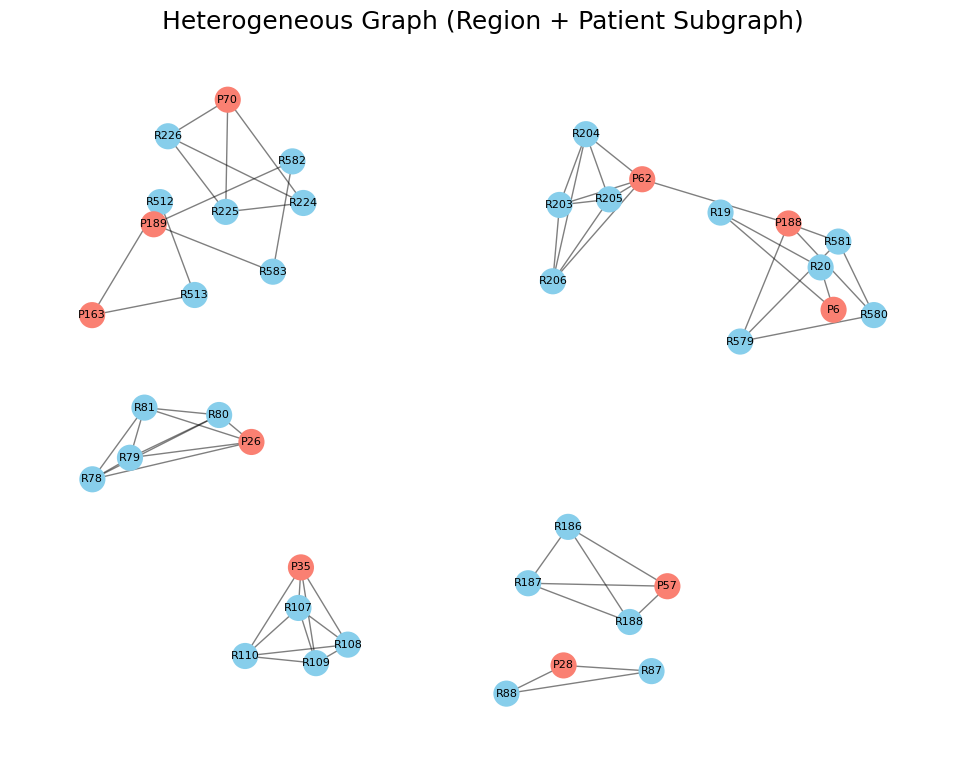

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# ---- PARAMETRI ----
NUM_PATIENTS_TO_PLOT = 10   # aumenta se vuoi più complessità
SEED = 42
random.seed(SEED)

# ---- Seleziona pazienti ----
all_patient_ids = list(patient_ids)
sample_patients = random.sample(all_patient_ids, NUM_PATIENTS_TO_PLOT)

sample_patient_idx = [patient_id_to_idx[p] for p in sample_patients]

# region indices appartenenti ai pazienti scelti
region_indices = df.index[df["Patient_Id"].astype(str).isin(sample_patients)].tolist()

region_set = set(region_indices)
patient_set = set(sample_patient_idx)

# ---- Crea grafo networkx ----
G = nx.Graph()

# --- aggiungi nodi ---
for r in region_indices:
    G.add_node(f"R{r}", node_type="region")

for p in sample_patient_idx:
    G.add_node(f"P{p}", node_type="patient")

# --- aggiungi region-region edges ---
edge_rr_np = edge_rr.cpu().numpy()
for i in range(edge_rr_np.shape[1]):
    src, dst = edge_rr_np[:, i]
    if src in region_set and dst in region_set:
        G.add_edge(f"R{src}", f"R{dst}", edge_type="rr")

# --- region -> patient edges ---
for r in region_indices:
    p = region_patient_idx[r].item()
    if p in patient_set:
        G.add_edge(f"R{r}", f"P{p}", edge_type="rp")

# --- patient-patient edges ---
edge_pp_np = edge_pp.cpu().numpy()
for i in range(edge_pp_np.shape[1]):
    src, dst = edge_pp_np[:, i]
    if src in patient_set and dst in patient_set:
        G.add_edge(f"P{src}", f"P{dst}", edge_type="pp")

print("Nodes:", len(G.nodes()), "Edges:", len(G.edges()))

# ---- Layout ----
pos = nx.spring_layout(G, seed=SEED, k=0.6)

# ---- Colori nodi ----
node_colors = []
for n in G.nodes():
    if G.nodes[n]["node_type"] == "region":
        node_colors.append("skyblue")
    else:
        node_colors.append("salmon")

# ---- Plot ----
plt.figure(figsize=(10, 8))

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Heterogeneous Graph (Region + Patient Subgraph)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import networkx as nx
import numpy as np

## Patient graph (undirected)
G_pat = nx.Graph()
G_pat.add_nodes_from(range(len(patient_ids)))

pp = edge_pp.cpu().numpy()
for i in range(pp.shape[1]):
    u, v = int(pp[0, i]), int(pp[1, i])
    if u != v:
        G_pat.add_edge(u, v)

n_nodes = G_pat.number_of_nodes()
n_edges = G_pat.number_of_edges()
components = list(nx.connected_components(G_pat))
n_comp = len(components)
largest = max(components, key=len)
largest_size = len(largest)

deg = np.array([d for _, d in G_pat.degree()])
deg_mean = deg.mean()
deg_median = np.median(deg)
deg_max = deg.max()

density = nx.density(G_pat)

print("PATIENT GRAPH")
print("nodes:", n_nodes, "| edges:", n_edges)
print("connected components:", n_comp)
print("largest component size:", largest_size, f"({largest_size/n_nodes:.1%} of patients)")
print("degree mean:", round(deg_mean, 2), "| median:", deg_median, "| max:", deg_max)
print("density:", round(density, 5))

## Clustering
clust = nx.average_clustering(G_pat)
print("avg clustering coefficient:", round(clust, 4))

PATIENT GRAPH
nodes: 244 | edges: 966
connected components: 1
largest component size: 244 (100.0% of patients)
degree mean: 7.92 | median: 7.0 | max: 17
density: 0.03258
avg clustering coefficient: 0.3076


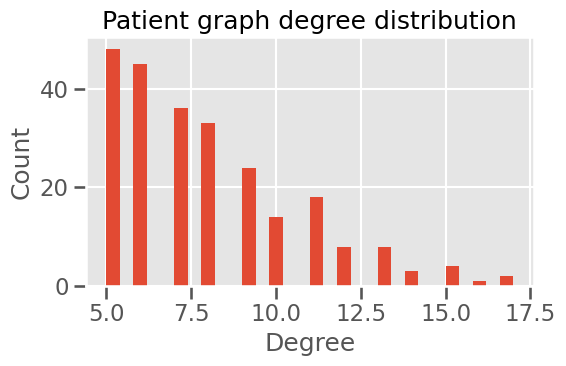

In [ ]:
## Plot degree
plt.figure(figsize = (6,4))
plt.hist(deg, bins = 30)
plt.title("Patient graph degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

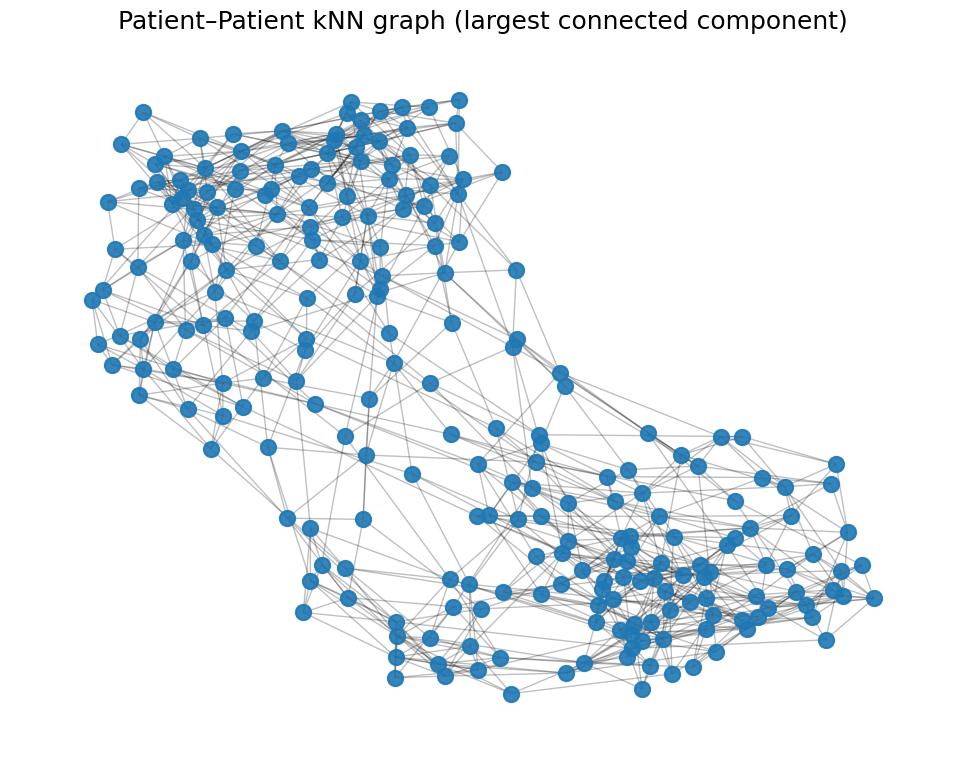

In [ ]:
## Patient level graph
## Largest connected component
largest_nodes = list(largest)
G_lcc = G_pat.subgraph(largest_nodes).copy()

## Layout
pos = nx.spring_layout(G_lcc, seed = 42)

plt.figure(figsize = (10,8))
nx.draw_networkx_nodes(G_lcc, pos, node_size = 120, alpha = 0.9)
nx.draw_networkx_edges(G_lcc, pos, alpha = 0.25, width = 1)
plt.title("Patient–Patient kNN graph (largest connected component)")
plt.axis("off")
plt.tight_layout()
plt.show()

##### Training - Evaluation

Epoch 001 | loss=1.4279 | val_macroF1=0.267 | best=0.267
Epoch 025 | loss=0.9115 | val_macroF1=0.559 | best=0.559
Epoch 050 | loss=0.6388 | val_macroF1=0.694 | best=0.697
Epoch 075 | loss=0.4800 | val_macroF1=0.739 | best=0.739
Epoch 100 | loss=0.3797 | val_macroF1=0.745 | best=0.745
Epoch 125 | loss=0.2834 | val_macroF1=0.713 | best=0.747
Epoch 150 | loss=0.2372 | val_macroF1=0.727 | best=0.748
Early stopping at epoch 171 (best val macro-F1=0.748)
Restored best model. best_val_macroF1 = 0.7483033960613108

TEST region-level acc=0.688 | macroF1=0.637

              precision    recall  f1-score   support

     Het - D      0.545     0.643     0.590        28
    Het - IE      0.458     0.524     0.489        21
     Hom - D      0.942     0.803     0.867        61
    Hom - IE      0.594     0.613     0.603        31

    accuracy                          0.688       141
   macro avg      0.635     0.646     0.637       141
weighted avg      0.715     0.688     0.698       141

Confusi

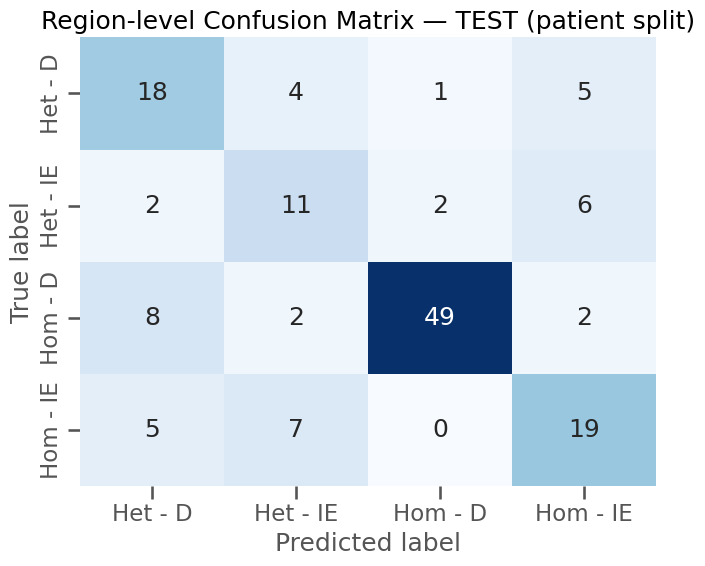

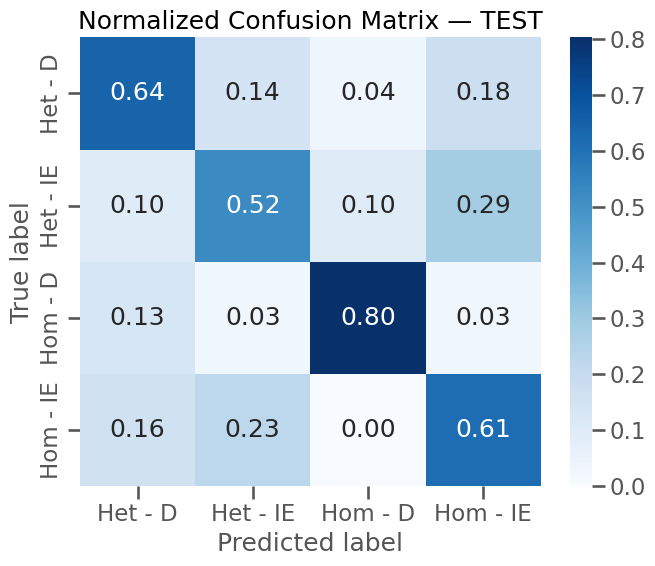

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

train_mask_r_d = train_mask_r.to(device)
val_mask_r_d   = val_mask_r.to(device)
test_mask_r_d  = test_mask_r.to(device)

model = HeteroSAGE_RegionClassifier(
    in_dim_region = data["region"].num_features,
    in_dim_patient = data["patient"].num_features,
    hidden = 32,
    out_classes = num_classes,
    num_layers = 2,
    dropout = 0.3
).to(device)

y = data["region"].y

## Class weights on region TRAIN
counts = torch.bincount(y[train_mask_r_d], minlength = num_classes).float()
class_w = (counts.sum() / (counts + 1e-6)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 1e-2)

best_val = -1.0
best_state = None
patience = 40
wait = 0
EPOCHS = 300

## Train
for epoch in range(1, EPOCHS + 1):
    model.train()
    opt.zero_grad()

    logits = model(data)
    loss = F.cross_entropy(logits[train_mask_r_d], y[train_mask_r_d], weight = class_w)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
    opt.step()

    model.eval()
    with torch.no_grad():
        logits = model(data)
        pred_val = logits[val_mask_r_d].argmax(dim=1).detach().cpu().numpy()
        true_val = y[val_mask_r_d].detach().cpu().numpy()
        val_f1 = f1_score(true_val, pred_val, average = "macro")

    if val_f1 > best_val + 1e-4:
        best_val = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1

    if epoch == 1 or epoch % 25 == 0:
        print(f"Epoch {epoch:03d} | loss={loss.item():.4f} | val_macroF1={val_f1:.3f} | best={best_val:.3f}")

    if wait >= patience:
        print(f"Early stopping at epoch {epoch} (best val macro-F1={best_val:.3f})")
        break

model.load_state_dict(best_state)
model.to(device)
print("Restored best model. best_val_macroF1 =", best_val)

## Test
model.eval()
with torch.no_grad():
    logits = model(data)
    pred_test = logits[test_mask_r_d].argmax(dim = 1).cpu().numpy()
    true_test = y[test_mask_r_d].cpu().numpy()

acc = accuracy_score(true_test, pred_test)
mf1 = f1_score(true_test, pred_test, average = "macro")
print(f"\nTEST region-level acc={acc:.3f} | macroF1={mf1:.3f}\n")

print(classification_report(true_test, pred_test, target_names = region_class_names, digits = 3))
print("Confusion matrix:\n", confusion_matrix(true_test, pred_test, labels = list(range(num_classes))))

## Confusion matrix
cm = confusion_matrix(
    true_test,
    pred_test,
    labels=list(range(num_classes))
)
print("Confusion matrix:\n", cm)

plt.figure(figsize = (7,6))
sns.heatmap(
    cm,
    annot = True,
    fmt = "d",
    cmap = "Blues",
    cbar = False,
    xticklabels = region_class_names,
    yticklabels = region_class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Region-level Confusion Matrix — TEST (patient split)")
plt.tight_layout()
plt.show()
cm_norm = cm.astype(float) / cm.sum(axis = 1, keepdims = True)

plt.figure(figsize = (7,6))
sns.heatmap(
    cm_norm,
    annot = True,
    fmt = ".2f",
    cmap = "Blues",
    cbar = True,
    xticklabels = region_class_names,
    yticklabels = region_class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix — TEST")
plt.tight_layout()
plt.show()

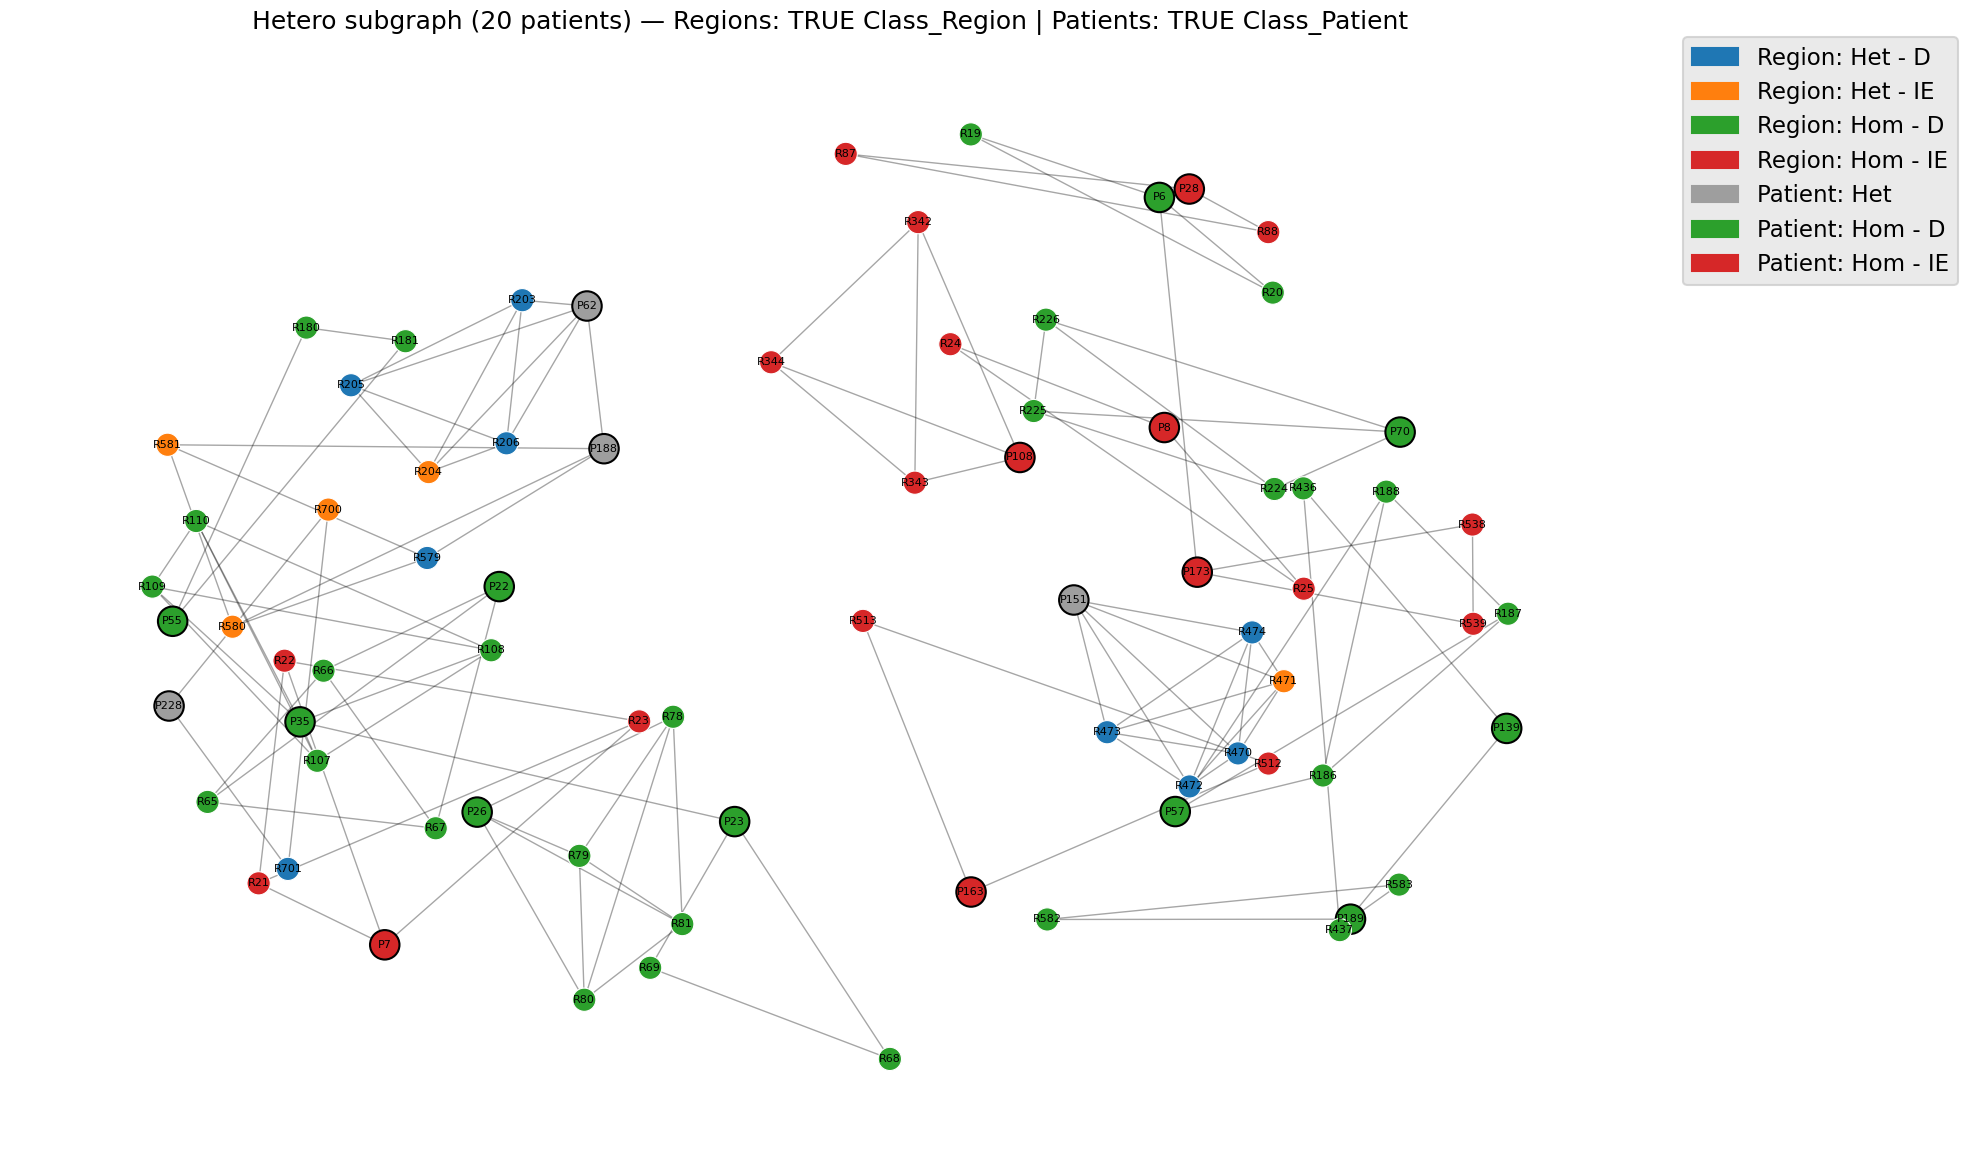

In [ ]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch

# ==========================================================
# ONE-CHUNK: plot hetero subgraph (regions + patients)
# - regions colored by TRUE/PRED Class_Region (manual colors, no pink)
# - patients colored by TRUE Class_Patient
# ==========================================================

# ---- params ----
SEED = 42
random.seed(SEED)

NUM_PATIENTS_TO_PLOT = 20   # <-- change here
COLOR_BY = "true"           # "true" or "pred"

# ---- palettes (EDIT names if your labels differ) ----
region_color_map = {
    "Het - D":  "#1f77b4",
    "Het - IE": "#ff7f0e",
    "Hom - D":  "#2ca02c",
    "Hom - IE": "#d62728",
}
default_region_color = "#333333"

patient_color_map = {
    "Het": "#9e9e9e",
    "Hom - D": "#2ca02c",
    "Hom - IE": "#d62728",
}
default_patient_color = "#9e9e9e"

# ---- patient true class mapping ----
patient_true_class = (df.groupby("Patient_Id")["Class_Patient"]
                        .agg(lambda s: s.value_counts().index[0])
                        .astype(str))

# ---- choose patients ----
sample_patients = random.sample(list(patient_ids), NUM_PATIENTS_TO_PLOT)
sample_patient_idx = [patient_id_to_idx[p] for p in sample_patients]

# regions belonging to these patients (df index assumed aligned to region node ids)
region_indices = df.index[df["Patient_Id"].astype(str).isin(sample_patients)].tolist()
region_set = set(region_indices)
patient_set = set(sample_patient_idx)

# ---- predictions (for COLOR_BY="pred") ----
model.eval()
with torch.no_grad():
    logits = model(data)

pred_all = logits.argmax(dim=1).detach().cpu().numpy()
true_all = data["region"].y.detach().cpu().numpy()

# ---- build graph ----
G = nx.Graph()

# nodes: regions
for r in region_indices:
    lab_idx = int(true_all[r] if COLOR_BY == "true" else pred_all[r])
    G.add_node(f"R{r}", node_type="region", label=lab_idx)

# nodes: patients
for p in sample_patient_idx:
    G.add_node(f"P{p}", node_type="patient")

# edges rr (region-region intra)
rr = edge_rr.detach().cpu().numpy()
for i in range(rr.shape[1]):
    u, v = int(rr[0, i]), int(rr[1, i])
    if u in region_set and v in region_set:
        G.add_edge(f"R{u}", f"R{v}", edge_type="rr")

# edges rp (region-patient)
for r in region_indices:
    p = int(region_patient_idx[r].item())
    if p in patient_set:
        G.add_edge(f"R{r}", f"P{p}", edge_type="rp")

# edges pp (patient-patient within sample)
pp = edge_pp.detach().cpu().numpy()
for i in range(pp.shape[1]):
    u, v = int(pp[0, i]), int(pp[1, i])
    if u in patient_set and v in patient_set:
        G.add_edge(f"P{u}", f"P{v}", edge_type="pp")

# ---- layout ----
pos = nx.spring_layout(G, seed=SEED, k=0.7)

# ---- node lists ----
patient_nodes = [n for n in G.nodes() if G.nodes[n]["node_type"] == "patient"]
region_nodes  = [n for n in G.nodes() if G.nodes[n]["node_type"] == "region"]

# ---- color helpers ----
def region_color_from_idx(idx):
    name = region_class_names[int(idx)]
    return region_color_map.get(name, default_region_color)

def patient_color_from_node(node):
    p_idx = int(node[1:])                  # "P57" -> 57
    pid_str = str(patient_ids[p_idx])      # e.g., "CRUK0001"
    p_class = patient_true_class.get(pid_str, "Het")
    return patient_color_map.get(p_class, default_patient_color)

region_colors = [region_color_from_idx(G.nodes[n]["label"]) for n in region_nodes]
patient_colors = [patient_color_from_node(n) for n in patient_nodes]

# ---- plot ----
plt.figure(figsize=(20, 12))
nx.draw_networkx_edges(G, pos, alpha=0.35, width=1)

# patients
nx.draw_networkx_nodes(
    G, pos,
    nodelist=patient_nodes,
    node_color=patient_colors,
    node_size=450,
    edgecolors="black",
    linewidths=1.5
)

# regions
nx.draw_networkx_nodes(
    G, pos,
    nodelist=region_nodes,
    node_color=region_colors,
    node_size=280,
    edgecolors="white",
    linewidths=0.8
)

nx.draw_networkx_labels(G, pos, font_size=8)

# ---- legend (regions) ----
handles_region = []
for i in range(len(region_class_names)):
    cname = region_class_names[i]
    # only include if appears in mapping or you want always include
    handles_region.append(mpatches.Patch(color=region_color_from_idx(i), label=f"Region: {cname}"))

# ---- legend (patients, only present classes) ----
present_patient_classes = sorted({
    patient_true_class.get(str(patient_ids[int(n[1:])]), "Het")
    for n in patient_nodes
})
handles_patient = [mpatches.Patch(color=patient_color_map.get(c, default_patient_color), label=f"Patient: {c}")
                   for c in present_patient_classes]

plt.legend(handles=handles_region + handles_patient,
           bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

plt.title(
    f"Hetero subgraph ({len(patient_nodes)} patients) — "
    f"Regions: {COLOR_BY.upper()} Class_Region | Patients: TRUE Class_Patient"
)
plt.axis("off")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


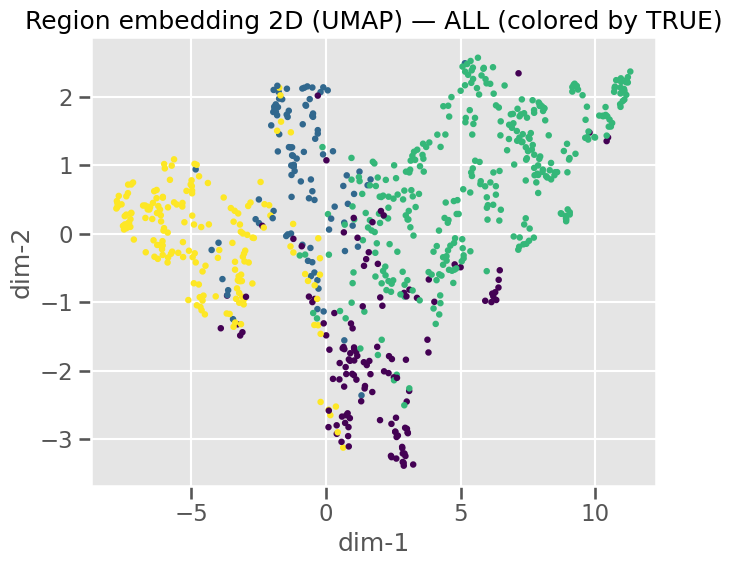

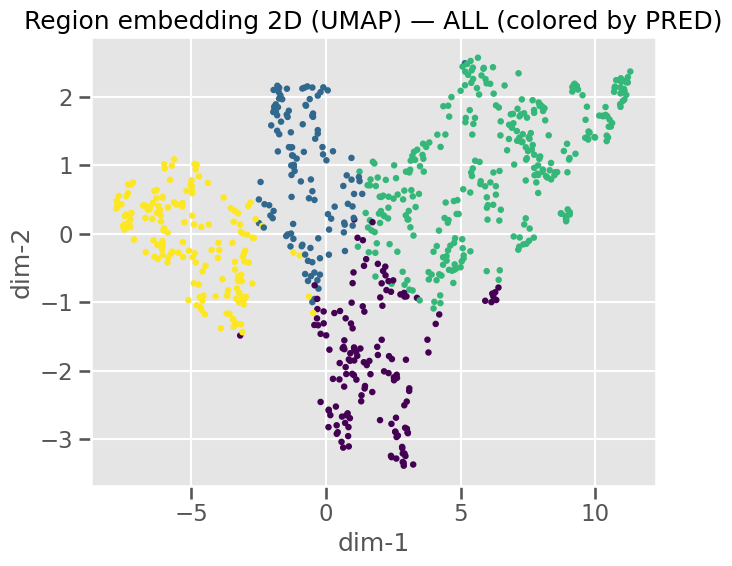

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


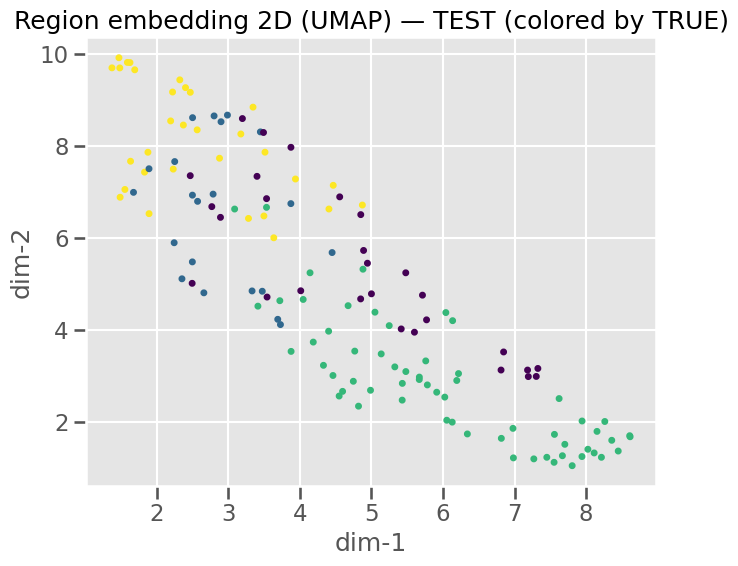

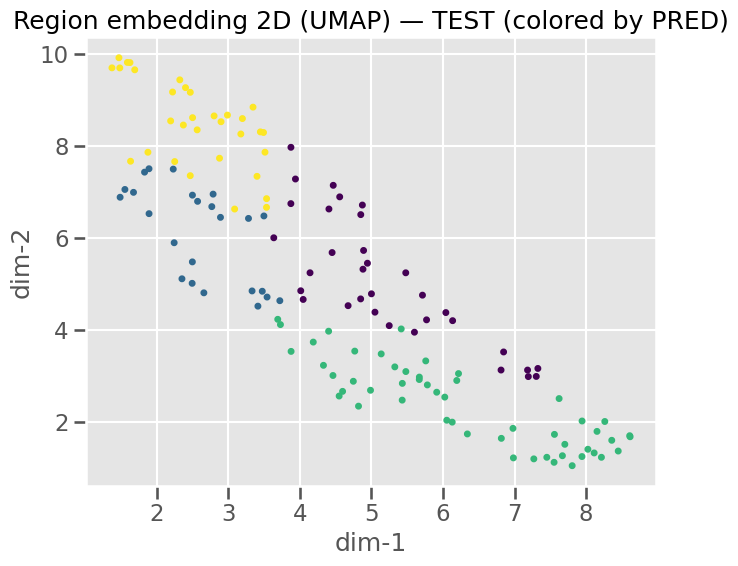

In [ ]:
## Embeddings

# ---- extract embeddings ----
model.eval()
with torch.no_grad():
    logits, emb_region = model(data, return_emb=True)

emb = emb_region.detach().cpu().numpy()
y_true = data["region"].y.detach().cpu().numpy()
y_pred = logits.argmax(dim=1).detach().cpu().numpy()

# masks
test_mask_np = test_mask_r.detach().cpu().numpy() if "test_mask_r" in globals() else test_mask_r_d.detach().cpu().numpy()

# ---- 2D projection: UMAP -> fallback to t-SNE ----
def project_2d(X, seed=42):
    try:
        import umap
        reducer = umap.UMAP(n_neighbors=25, min_dist=0.2, random_state=seed)
        Z = reducer.fit_transform(X)
        method = "UMAP"
    except Exception:
        from sklearn.manifold import TSNE
        Z = TSNE(n_components=2, perplexity=30, random_state=seed, init="pca").fit_transform(X)
        method = "t-SNE"
    return Z, method

# all regions
Z_all, method = project_2d(emb, seed=42)

plt.figure(figsize=(7,6))
plt.scatter(Z_all[:,0], Z_all[:,1], c=y_true, s=10)
plt.title(f"Region embedding 2D ({method}) — ALL (colored by TRUE)")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,6))
plt.scatter(Z_all[:,0], Z_all[:,1], c=y_pred, s=10)
plt.title(f"Region embedding 2D ({method}) — ALL (colored by PRED)")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.tight_layout()
plt.show()

# test-only regions
Z_test, method_test = project_2d(emb[test_mask_np], seed = 42)

plt.figure(figsize = (7,6))
plt.scatter(Z_test[:,0], Z_test[:,1], c = y_true[test_mask_np], s = 12)
plt.title(f"Region embedding 2D ({method_test}) — TEST (colored by TRUE)")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,6))
plt.scatter(Z_test[:,0], Z_test[:,1], c = y_pred[test_mask_np], s=12)
plt.title(f"Region embedding 2D ({method_test}) — TEST (colored by PRED)")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.tight_layout()
plt.show()

##### Prediction

In [ ]:
## Load data
df_park = pd.read_csv(os.path.join(data_path, "ssgsea_29sign_PARK_rowsum0.txt"), index_col=0, sep="\t")
df_suc  = pd.read_csv(os.path.join(data_path, "score_suc_final.csv"), index_col=0)
df_gr   = pd.read_csv(os.path.join(data_path, "score_gr_final.csv"), index_col=0)
df_ire  = pd.read_csv(os.path.join(data_path, "Dataset_29sign_IRE_scaled_100pazienti.txt"), index_col=0, sep="\t")
df_oak  = pd.read_csv(os.path.join(data_path, "score_oakpop.csv"), index_col=0)
df_tcga = pd.read_csv(os.path.join(data_path, "ssGSEA_scores_29immunosign_NSCLC_starTPM_TCGA_Scale.tsv"), index_col=0, sep="\t")

## Filtering
features_cols = ["MHCI", "MHCII", "Coactivation_molecules", "Effector_cells", "T_cell_traffic", "NK_cells", "T_cells", "B_cells",
                 "M1_signatures", "Th1_signature", "Antitumor_cytokines", "Checkpoint_inhibition", "Treg", "T_reg_traffic", "MDSC",
                 "MDSC_traffic", "Macrophages", "Macrophage_DC_traffic", "Th2_signature"]
df_park = df_park[features_cols]
df_suc = df_suc[features_cols]
df_gr = df_gr[features_cols]
df_ire = df_ire[features_cols]
df_oak = df_oak[features_cols]
df_tcga = df_tcga[features_cols]

external = {
    "PARK": df_park,
    "SUC": df_suc,
    "GR": df_gr,
    "IRE": df_ire,
    "OAKPOP": df_oak,
    "TCGA": df_tcga,
}

out_dir = "external_prediction"
os.makedirs(out_dir, exist_ok = True)


import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from sklearn.neighbors import NearestNeighbors

# -------------------------
# Params
# -------------------------
K_PATIENT = K_PATIENT
METRIC = "cosine"

os.makedirs(out_dir, exist_ok=True)
device = next(model.parameters()).device

# -------------------------
# Feature alignment
# -------------------------
def align_features(df_ext: pd.DataFrame, feature_cols):
    X = df_ext.copy()
    X = X.apply(pd.to_numeric, errors="coerce")

    missing = [c for c in feature_cols if c not in X.columns]
    for c in missing:
        X[c] = 0.0

    extra = [c for c in X.columns if c not in feature_cols]
    if len(extra) > 0:
        X = X.drop(columns=extra)

    X = X[feature_cols].fillna(0.0)
    return X

# -------------------------
# Build heterodata for patient-row table (pseudo-region 1:1)
# -------------------------
def build_patientrow_heterodata(X_df: pd.DataFrame, k_patient=5, metric="euclidean"):
    patient_ids_ext = X_df.index.astype(str).values
    N = len(patient_ids_ext)

    data_ext = HeteroData()

    x_region = torch.tensor(X_df.values, dtype=torch.float)  # [N,F]
    x_patient = x_region.clone()                             # [N,F]

    data_ext["region"].x = x_region
    data_ext["patient"].x = x_patient

    idx = torch.arange(N, dtype=torch.long)
    data_ext["region", "belongs_to", "patient"].edge_index = torch.stack([idx, idx], dim=0)
    data_ext["patient", "has_region", "region"].edge_index = torch.stack([idx, idx], dim=0)

    # patient-patient kNN
    kk = min(k_patient, N - 1) if N > 1 else 0
    rows = []
    if kk > 0:
        nnbr = NearestNeighbors(n_neighbors=kk + 1, metric=metric).fit(X_df.values)
        neigh = nnbr.kneighbors(X_df.values, return_distance=False)
        for i in range(N):
            for j in neigh[i, 1:]:
                rows.append((i, int(j)))
                rows.append((int(j), i))
    edge_pp = torch.tensor(rows, dtype=torch.long).t().contiguous() if len(rows) else torch.empty((2,0), dtype = torch.long)
    data_ext["patient", "knn", "patient"].edge_index = edge_pp

    # empty rr (needed because model expects this relation key)
    data_ext["region", "intra", "region"].edge_index = torch.empty((2,0), dtype = torch.long)

    return data_ext, patient_ids_ext

# -------------------------
# FULL GNN inference loop
# -------------------------
model.eval()

for cohort_name, df_ext in external.items():
    # 1) align features
    X_df = align_features(df_ext, feature_cols)

    # 2) build heterodata
    data_ext, sample_ids = build_patientrow_heterodata(X_df, k_patient = K_PATIENT, metric = METRIC)
    data_ext = data_ext.to(device)

    # 3) inference
    with torch.no_grad():
        logits = model(data_ext)                     #[N, C]
        prob = F.softmax(logits, dim=1).cpu().numpy()
        pred = logits.argmax(dim=1).cpu().numpy()

    pred_names = np.array([region_class_names[i] for i in pred])
    counts = pd.Series(pred_names).value_counts()

        # 4) save con nome richiesto
    out = pd.DataFrame(index=sample_ids)
    out.index.name = "sample_id"
    out["pred_class_idx"] = pred.astype(int)
    out["pred_class_name"] = pred_names

    for i, cname in enumerate(region_class_names):
        out[f"p_{cname}"] = prob[:, i]

    out_path = os.path.join(out_dir, f"pred_{cohort_name}.csv")
    out.to_csv(out_path)

    print(f"[{cohort_name}] saved -> {out_path}")
    print(counts, "\n")

zip_path = shutil.make_archive("external_prediction", 'zip', "external_prediction")
print("Created:", zip_path)

files.download(zip_path)

[PARK] saved -> external_prediction/pred_PARK.csv
Hom - D     149
Het - IE    102
Hom - IE     56
Het - D      48
Name: count, dtype: int64 

[SUC] saved -> external_prediction/pred_SUC.csv
Hom - D     69
Het - IE    30
Het - D     28
Hom - IE    25
Name: count, dtype: int64 

[GR] saved -> external_prediction/pred_GR.csv
Hom - D     52
Hom - IE    22
Het - IE    21
Het - D     12
Name: count, dtype: int64 

[IRE] saved -> external_prediction/pred_IRE.csv
Hom - D     42
Het - IE    31
Hom - IE    15
Het - D     12
Name: count, dtype: int64 

[OAKPOP] saved -> external_prediction/pred_OAKPOP.csv
Hom - D     169
Het - IE    125
Hom - IE     82
Het - D      63
Name: count, dtype: int64 

[TCGA] saved -> external_prediction/pred_TCGA.csv
Hom - D     421
Het - IE    272
Hom - IE    206
Het - D     132
Name: count, dtype: int64 

Created: /content/external_prediction.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Comparison with MLP


===== GNN (HeteroSAGE) — TEST =====
acc=0.688 | macroF1=0.637

              precision    recall  f1-score   support

     Het - D      0.545     0.643     0.590        28
    Het - IE      0.458     0.524     0.489        21
     Hom - D      0.942     0.803     0.867        61
    Hom - IE      0.594     0.613     0.603        31

    accuracy                          0.688       141
   macro avg      0.635     0.646     0.637       141
weighted avg      0.715     0.688     0.698       141



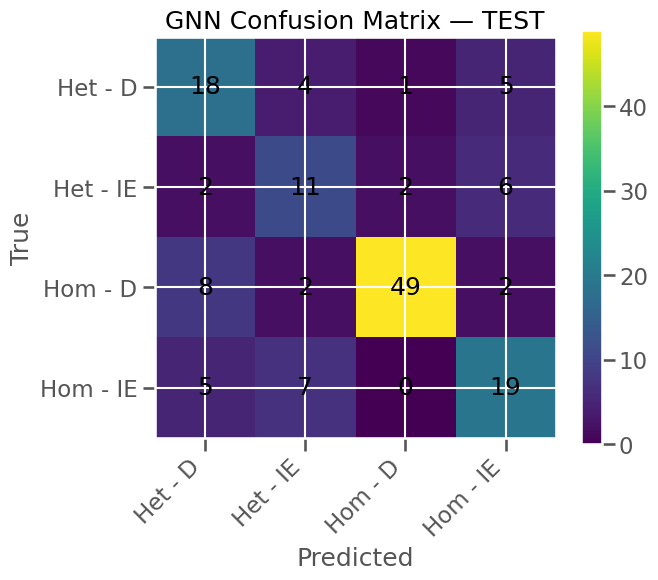

GNN silhouette TEST (TRUE): 0.0564
GNN silhouette TEST (PRED): 0.1787


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


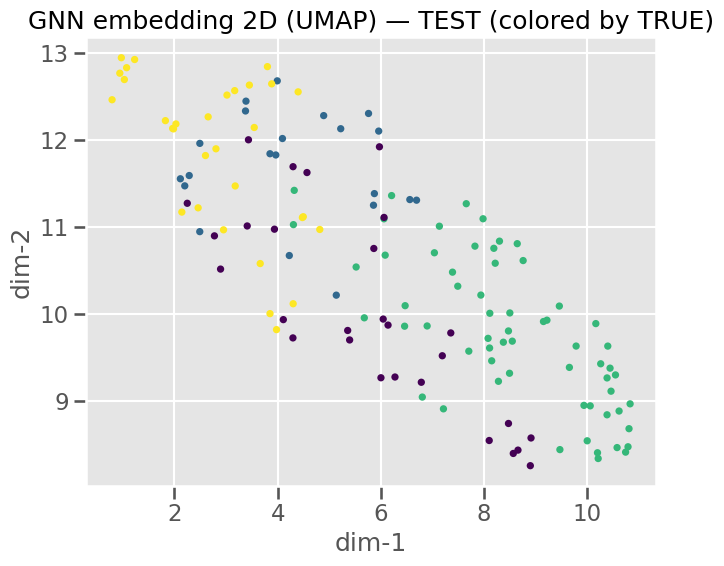

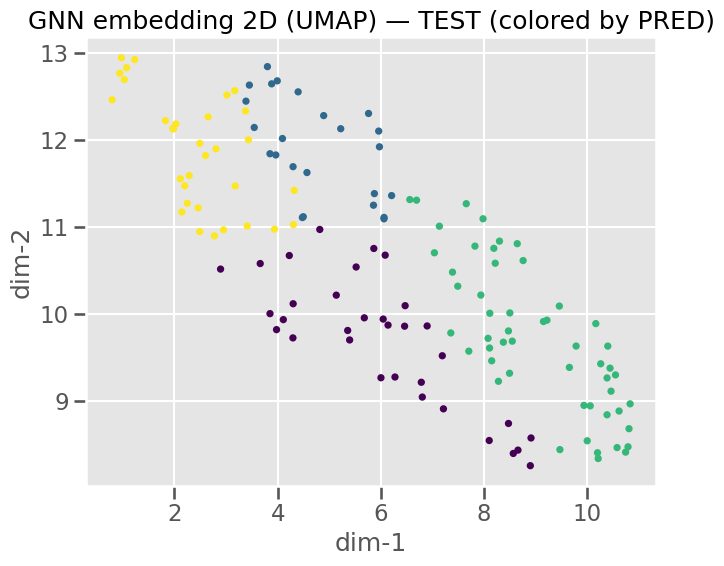

[MLP] Epoch 001 | loss=1.4082 | val_macroF1=0.072 | best=0.072
[MLP] Epoch 025 | loss=1.1006 | val_macroF1=0.453 | best=0.469
[MLP] Epoch 050 | loss=0.9234 | val_macroF1=0.472 | best=0.472
[MLP] Epoch 075 | loss=0.8140 | val_macroF1=0.511 | best=0.533
[MLP] Epoch 100 | loss=0.7670 | val_macroF1=0.531 | best=0.536
[MLP] Epoch 125 | loss=0.7105 | val_macroF1=0.540 | best=0.559
[MLP] Early stopping at epoch 144 (best val macro-F1=0.559)

===== MLP (no graph) — TEST =====
acc=0.546 | macroF1=0.515

              precision    recall  f1-score   support

     Het - D      0.297     0.393     0.338        28
    Het - IE      0.379     0.524     0.440        21
     Hom - D      0.809     0.623     0.704        61
    Hom - IE      0.607     0.548     0.576        31

    accuracy                          0.546       141
   macro avg      0.523     0.522     0.515       141
weighted avg      0.599     0.546     0.564       141



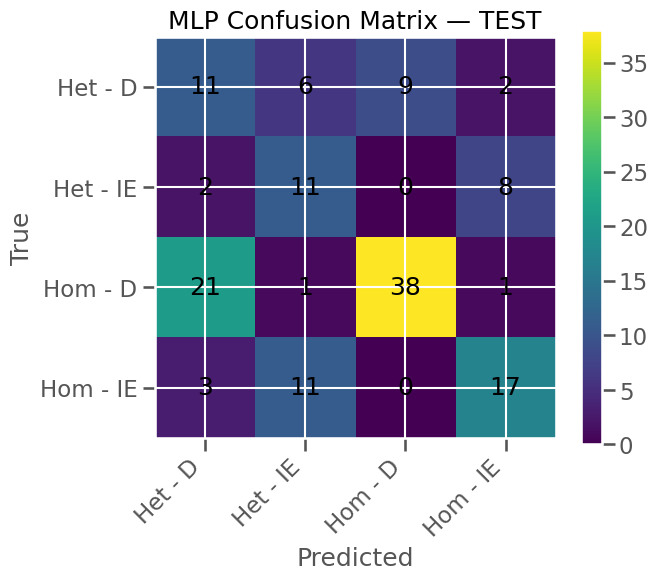

MLP silhouette TEST (TRUE): 0.0072
MLP silhouette TEST (PRED): 0.1701


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


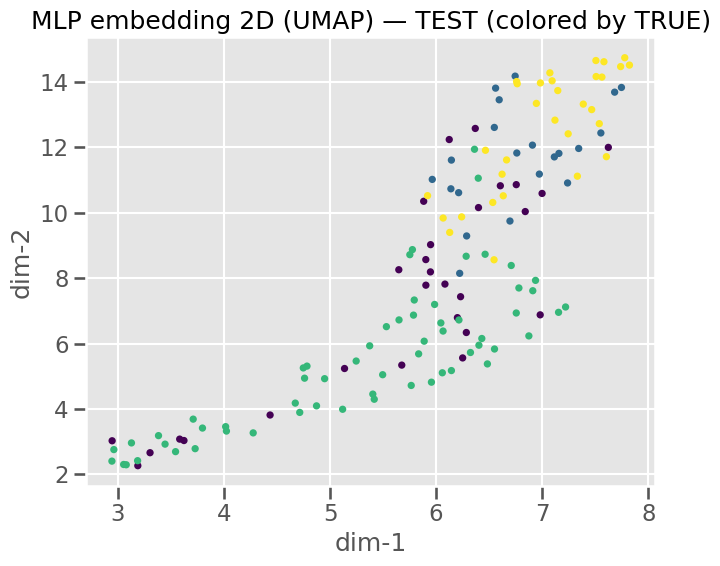

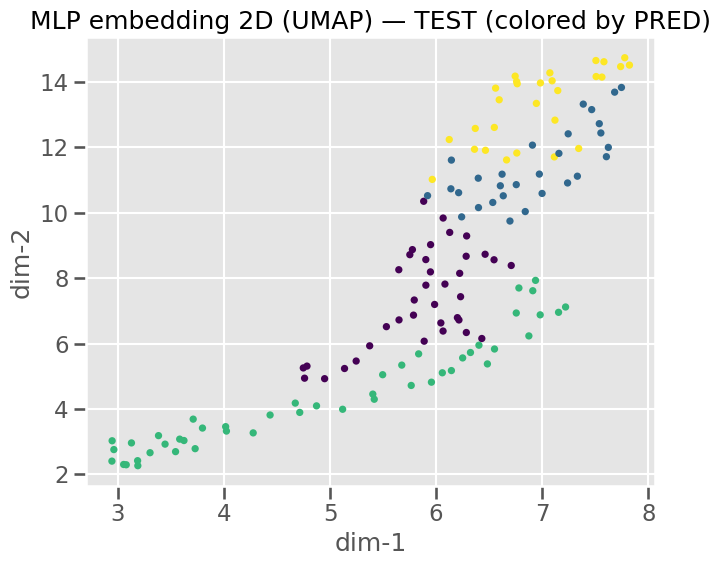


===== SUMMARY (TEST) =====
GNN: acc=0.688 | macroF1=0.637 | sil_TRUE=0.056 | sil_PRED=0.179
MLP: acc=0.546 | macroF1=0.515 | sil_TRUE=0.007 | sil_PRED=0.170


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score

# --------------------------
# Helpers: UMAP projection
# --------------------------
def project_2d(X, seed=42):
    try:
        import umap
        reducer = umap.UMAP(n_neighbors=25, min_dist=0.2, random_state=seed)
        Z = reducer.fit_transform(X)
        method = "UMAP"
    except Exception:
        from sklearn.manifold import TSNE
        Z = TSNE(n_components=2, perplexity=30, random_state=seed, init="pca").fit_transform(X)
        method = "t-SNE"
    return Z, method

def plot_cm(cm, class_names, title):
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    # annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()

# --------------------------
# 1) Evaluate GNN (already trained)
# --------------------------
device = next(model.parameters()).device
y = data["region"].y
x = data["region"].x

model.eval()
with torch.no_grad():
    logits_gnn, emb_gnn = model(data, return_emb=True)

pred_gnn_test = logits_gnn[test_mask_r_d].argmax(dim=1).detach().cpu().numpy()
true_test = y[test_mask_r_d].detach().cpu().numpy()

acc_gnn = accuracy_score(true_test, pred_gnn_test)
mf1_gnn = f1_score(true_test, pred_gnn_test, average="macro")
cm_gnn = confusion_matrix(true_test, pred_gnn_test, labels=list(range(num_classes)))

print("\n===== GNN (HeteroSAGE) — TEST =====")
print(f"acc={acc_gnn:.3f} | macroF1={mf1_gnn:.3f}\n")
print(classification_report(true_test, pred_gnn_test, target_names=region_class_names, digits=3))
plot_cm(cm_gnn, region_class_names, "GNN Confusion Matrix — TEST")

# silhouette on embeddings (NOT UMAP) — TEST
emb_gnn_np = emb_gnn.detach().cpu().numpy()
emb_gnn_test = emb_gnn_np[test_mask_r_d.detach().cpu().numpy()]
y_pred_gnn_all = logits_gnn.argmax(dim=1).detach().cpu().numpy()
y_pred_gnn_test = y_pred_gnn_all[test_mask_r_d.detach().cpu().numpy()]

sil_gnn_true_test = silhouette_score(emb_gnn_test, true_test)
sil_gnn_pred_test = silhouette_score(emb_gnn_test, y_pred_gnn_test)

print(f"GNN silhouette TEST (TRUE): {sil_gnn_true_test:.4f}")
print(f"GNN silhouette TEST (PRED): {sil_gnn_pred_test:.4f}")

# UMAP plots for GNN — TEST
Z_gnn_test, method = project_2d(emb_gnn_test, seed=42)

plt.figure(figsize=(7,6))
plt.scatter(Z_gnn_test[:,0], Z_gnn_test[:,1], c=true_test, s=14)
plt.title(f"GNN embedding 2D ({method}) — TEST (colored by TRUE)")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,6))
plt.scatter(Z_gnn_test[:,0], Z_gnn_test[:,1], c=y_pred_gnn_test, s=14)
plt.title(f"GNN embedding 2D ({method}) — TEST (colored by PRED)")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.tight_layout(); plt.show()


# --------------------------
# 2) MLP Baseline (no graph)
# --------------------------
class MLPRegionClassifier(nn.Module):
    def __init__(self, in_dim, hidden=64, out_classes=4, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.out = nn.Linear(hidden, out_classes)
        self.dropout = dropout

    def forward(self, x, return_emb=False):
        h = F.relu(self.fc1(x))
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = F.relu(self.fc2(h))
        h = F.dropout(h, p=self.dropout, training=self.training)
        logits = self.out(h)
        if return_emb:
            return logits, h
        return logits

mlp = MLPRegionClassifier(
    in_dim=data["region"].num_features,
    hidden=64,
    out_classes=num_classes,
    dropout=0.3
).to(device)

# class weights from TRAIN
counts = torch.bincount(y[train_mask_r_d], minlength=num_classes).float()
class_w = (counts.sum() / (counts + 1e-6)).to(device)

opt = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=1e-2)

best_val = -1.0
best_state = None
patience = 40
wait = 0
EPOCHS = 300

for epoch in range(1, EPOCHS+1):
    mlp.train()
    opt.zero_grad()

    logits = mlp(x)
    loss = F.cross_entropy(logits[train_mask_r_d], y[train_mask_r_d], weight=class_w)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(mlp.parameters(), 2.0)
    opt.step()

    mlp.eval()
    with torch.no_grad():
        logits = mlp(x)
        pred_val = logits[val_mask_r_d].argmax(dim=1).detach().cpu().numpy()
        true_val = y[val_mask_r_d].detach().cpu().numpy()
        val_f1 = f1_score(true_val, pred_val, average="macro")

    if val_f1 > best_val + 1e-4:
        best_val = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in mlp.state_dict().items()}
        wait = 0
    else:
        wait += 1

    if epoch == 1 or epoch % 25 == 0:
        print(f"[MLP] Epoch {epoch:03d} | loss={loss.item():.4f} | val_macroF1={val_f1:.3f} | best={best_val:.3f}")

    if wait >= patience:
        print(f"[MLP] Early stopping at epoch {epoch} (best val macro-F1={best_val:.3f})")
        break

mlp.load_state_dict(best_state)
mlp.eval()

with torch.no_grad():
    logits_mlp, emb_mlp = mlp(x, return_emb=True)

pred_mlp_test = logits_mlp[test_mask_r_d].argmax(dim=1).detach().cpu().numpy()

acc_mlp = accuracy_score(true_test, pred_mlp_test)
mf1_mlp = f1_score(true_test, pred_mlp_test, average="macro")
cm_mlp = confusion_matrix(true_test, pred_mlp_test, labels=list(range(num_classes)))

print("\n===== MLP (no graph) — TEST =====")
print(f"acc={acc_mlp:.3f} | macroF1={mf1_mlp:.3f}\n")
print(classification_report(true_test, pred_mlp_test, target_names=region_class_names, digits=3))
plot_cm(cm_mlp, region_class_names, "MLP Confusion Matrix — TEST")

# silhouette on MLP embeddings — TEST
emb_mlp_np = emb_mlp.detach().cpu().numpy()
emb_mlp_test = emb_mlp_np[test_mask_r_d.detach().cpu().numpy()]
y_pred_mlp_all = logits_mlp.argmax(dim=1).detach().cpu().numpy()
y_pred_mlp_test = y_pred_mlp_all[test_mask_r_d.detach().cpu().numpy()]

sil_mlp_true_test = silhouette_score(emb_mlp_test, true_test)
sil_mlp_pred_test = silhouette_score(emb_mlp_test, y_pred_mlp_test)

print(f"MLP silhouette TEST (TRUE): {sil_mlp_true_test:.4f}")
print(f"MLP silhouette TEST (PRED): {sil_mlp_pred_test:.4f}")

# UMAP plots for MLP — TEST
Z_mlp_test, method2 = project_2d(emb_mlp_test, seed=42)

plt.figure(figsize=(7,6))
plt.scatter(Z_mlp_test[:,0], Z_mlp_test[:,1], c=true_test, s=14)
plt.title(f"MLP embedding 2D ({method2}) — TEST (colored by TRUE)")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,6))
plt.scatter(Z_mlp_test[:,0], Z_mlp_test[:,1], c=y_pred_mlp_test, s=14)
plt.title(f"MLP embedding 2D ({method2}) — TEST (colored by PRED)")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.tight_layout(); plt.show()

# --------------------------
# 3) Summary
# --------------------------
print("\n===== SUMMARY (TEST) =====")
print(f"GNN: acc={acc_gnn:.3f} | macroF1={mf1_gnn:.3f} | sil_TRUE={sil_gnn_true_test:.3f} | sil_PRED={sil_gnn_pred_test:.3f}")
print(f"MLP: acc={acc_mlp:.3f} | macroF1={mf1_mlp:.3f} | sil_TRUE={sil_mlp_true_test:.3f} | sil_PRED={sil_mlp_pred_test:.3f}")